Define functions to load in tables of varying depth

In [1]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df

def depth1_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = df[df['num_group1'] == 0]
    filfeats = filfeats.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    df = df[df['num_group1'] == 0]
    df = df[df['num_group2'] == 0]
    filterdf = df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    return pd.merge(filterdf, aggfeats, how='left', on='case_id') 

In [1]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df
def depth1_feats(df):
    # Filter first
    filtered_df = df[df['num_group1'] == 0]
    
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = filtered_df.groupby('case_id')[numeric_cols].agg('sum').reset_index()
    
    notnum_cols = filtered_df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = filtered_df.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    # Filter first
    filtered_df = df[(df['num_group1'] == 0) & (df['num_group2'] == 0)]
    
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = filtered_df.groupby('case_id')[numeric_cols].agg('sum').reset_index()
    
    notnum_cols = filtered_df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filterdf = filtered_df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    
    return pd.merge(filterdf, aggfeats, how='left', on='case_id')

Load in base table

In [2]:
path = '/rds/general/user/ms2524/home/amexproject/parquet_files/train/train_'
base_cba = pd.read_parquet(path + "base.parquet", columns=['case_id','WEEK_NUM','target'])

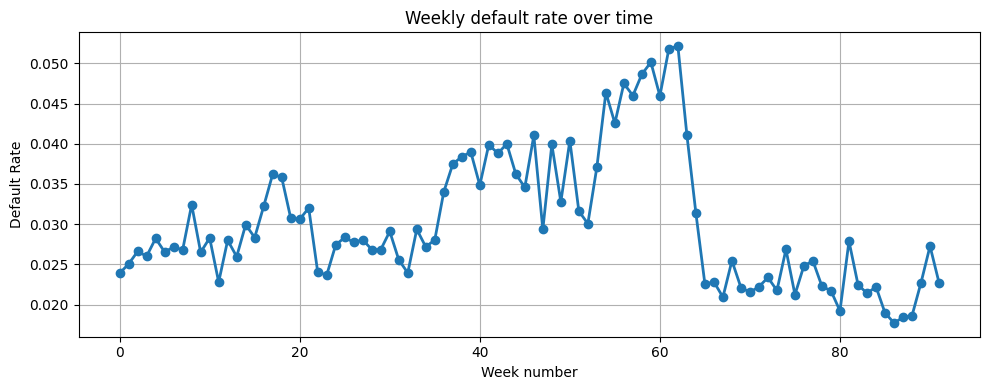

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

weekly_defaults = (
    base_cba
    .groupby('WEEK_NUM')['target']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(weekly_defaults['WEEK_NUM'], weekly_defaults['target'], marker='o', linewidth=2)
plt.title('Weekly default rate over time')
plt.xlabel('Week number')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/weekly_default_rate.pdf', format='pdf')
plt.show()


## Depth = 2

### Credit Bureua A

In [3]:
all_chunks = []
for id in range(11):
    df = filter_df(f'credit_bureau_a_2_{id}')
    processed = depth2_feats(df)
    all_chunks.append(processed)

# Concatenate everything at once
tmp = pd.concat(all_chunks, ignore_index=True)

# Merge with base
data_cba = pd.merge(base_cba, tmp, how="left", on="case_id")


### Previous application

In [4]:
data_appl = pd.merge(
    base_cba,
    depth2_feats(filter_df('applprev_2')),
    how="left",
    on="case_id"
)


## Depth = 1

### Credit Bureua A

In [5]:
data_cba = pd.merge(
    data_cba,
    depth1_feats(pd.concat([filter_df(f'credit_bureau_a_1_{id}') for id in range(4)])),
    how="left",
    on="case_id"
)

### Previous application

In [6]:
data_appl = pd.merge(
    data_appl,
    depth1_feats(pd.concat([filter_df(f'applprev_1_{id}') for id in range(2)])),
    how="left",
    on="case_id"
)


### Train person

In [7]:
data_person_1_train = pd.merge(
    base_cba,
    depth1_feats(filter_df('person_1')),
    how="left",
    on="case_id"
)

## Depth = 0

### Train Static

In [8]:
columns_to_keep = [
    'case_id', 'annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 
    'eir_270L', 'pmtnum_254L', 'lastst_736L', 'totalsettled_863A', 
    'numrejects9m_859L', 'currdebt_22A'
]

data_static_train = pd.merge(
    base_cba,
    pd.concat([
        filter_df(f'static_0_{id}')[columns_to_keep]
        for id in range(2)
    ], ignore_index=True),
    how="left",
    on="case_id"
)

## Feature selection 

In [9]:
for col in data_cba.columns:
    if col.endswith('D'):
        data_cba[col] = pd.to_datetime(data_cba[col], errors='coerce')


for col in data_cba.select_dtypes(include=['object']).columns:
    data_cba[col] = data_cba[col].astype('category')

for col in data_appl.columns:
    if col.endswith('D'):
        data_appl[col] = pd.to_datetime(data_appl[col], errors='coerce')

for col in data_appl.select_dtypes(include=['object']).columns:
    data_appl[col] = data_appl[col].astype('category')

for col in data_static_train.columns:
    if col.endswith('D'):
        data_static_train[col] = pd.to_datetime(data_static_train[col], errors='coerce')

for col in data_static_train.select_dtypes(include=['object']).columns:
    data_static_train[col] = data_static_train[col].astype('category')

for col in data_person_1_train.columns:
    if col.endswith('D'):
        data_person_1_train[col] = pd.to_datetime(data_person_1_train[col], errors='coerce')

for col in data_person_1_train.select_dtypes(include=['object']).columns:
    data_person_1_train[col] = data_person_1_train[col].astype('category')

In [10]:
import numpy as np
cb_features = ['case_id', 'WEEK_NUM','pmts_dpd_1073P', 'pmts_dpd_303P', 'dpdmax_139P', 'numberofoverdueinstlmax_1039L', 'numberofoverdueinstls_725L', 'collaterals_typeofguarante_359M', 'classificationofcontr_400M', 'subjectrole_93M', 'target']
data1_cba=data_cba[cb_features]
data1_cba = data1_cba.copy()
data1_cba.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

applprev_features = ['case_id', 'WEEK_NUM','maxdpdtolerance_577P', 'cacccardblochreas_147M', 'rejectreason_755M','target']
data1_appl=data_appl[applprev_features]
data1_appl = data1_appl.copy()
data1_appl.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

static_features = ['case_id', 'WEEK_NUM','annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 'eir_270L', 'pmtnum_254L', 'lastst_736L']
data_static_train_1 = data_static_train[static_features]
data_static_train_1 = data_static_train_1.copy()
data_static_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

person_features = ['case_id', 'WEEK_NUM','personindex_1023L', 'persontype_1072L', 'persontype_792L', 'empladdr_zipcode_114M', 'incometype_1044T', 'safeguarantyflag_411L', 'type_25L','target']
data_person_1_train_1 = data_person_1_train[person_features]
data_person_1_train_1 = data_person_1_train_1.copy()
data_person_1_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np


# Split by WEEK_NUM into equal segments
def split_by_week(df, n):
    min_week = df["WEEK_NUM"].min()
    max_week = df["WEEK_NUM"].max()
    bins = np.linspace(min_week, max_week + 1, n + 1, dtype=int)

    segments = {}
    for i in range(n):
        lower = bins[i]
        upper = bins[i + 1]
        key = f"split_{i}"
        segments[key] = df[(df["WEEK_NUM"] >= lower) & (df["WEEK_NUM"] < upper)].copy()

    return segments

def preprocess_split(train_df, test_df):
    exclude_columns = {'case_id', 'WEEK_NUM', 'target'}
    numcols = []
    catcols = []

    # Separate numeric and categorical columns
    for col in train_df.columns:
        if col in exclude_columns:
            continue
        if pd.api.types.is_numeric_dtype(train_df[col]):
            numcols.append(col)
        elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
            catcols.append(col)

    # Impute numeric columns
    for col in numcols:
        if train_df[col].isnull().any():
            strategy = 'median' if abs(train_df[col].skew()) > 0.5 else 'mean'
            imputer = SimpleImputer(strategy=strategy)
            train_df[[col]] = imputer.fit_transform(train_df[[col]])
            test_df[[col]] = imputer.transform(test_df[[col]])

    # Handle categorical columns: fill NA with "Unknown"
    for col in catcols:
        for df in [train_df, test_df]:
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("Unknown")

        # Fill missing values
        train_df[col] = train_df[col].fillna("Unknown")
        test_df[col] = test_df[col].fillna("Unknown")

    # Ordinal encode
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[catcols] = encoder.fit_transform(train_df[catcols])
    test_df[catcols] = encoder.transform(test_df[catcols])

    return train_df, test_df

def preprocess_all_segments(df, n):
    segments = split_by_week(df, n)
    base_train = segments["split_0"].copy()
    processed_segments = {}

    for key, segment_df in segments.items():
        train_proc, test_proc = preprocess_split(base_train.copy(), segment_df.copy())
        processed_segments[key] = test_proc

    return processed_segments

In [12]:
def merge_all_segments(cba_splits, static_splits, person_splits, appl_splits):
    merged_segments = {}

    drop_cols = ['WEEK_NUM', 'target']

    for split_name in cba_splits:
        cba = cba_splits[split_name]
        static = static_splits[split_name].drop(columns=[col for col in drop_cols if col in static_splits[split_name].columns])
        person = person_splits[split_name].drop(columns=[col for col in drop_cols if col in person_splits[split_name].columns])
        appl = appl_splits[split_name].drop(columns=[col for col in drop_cols if col in appl_splits[split_name].columns])

        merged = cba.merge(static, on="case_id", how="inner") \
                    .merge(person, on="case_id", how="inner") \
                    .merge(appl, on="case_id", how="inner")

        merged_segments[split_name] = merged

    return merged_segments


In [13]:
n_segments = 92

cba_proc = preprocess_all_segments(data1_cba, n=n_segments)
static_proc = preprocess_all_segments(data_static_train_1, n=n_segments)
person_proc = preprocess_all_segments(data_person_1_train_1, n=n_segments)
appl_proc = preprocess_all_segments(data1_appl, n=n_segments)

final_segments = merge_all_segments(cba_proc, static_proc, person_proc, appl_proc)

/rds/general/user/ms2524/ephemeral/ipykernel_2598666/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_2598666/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_2598666/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral

In [14]:
all_case_ids = []

for split_name, df in final_segments.items():
    all_case_ids.extend(df['case_id'].tolist())

total_case_ids = len(all_case_ids)
unique_case_ids = len(set(all_case_ids))

print(f"Total case_ids (merged segments, with duplicates): {total_case_ids}")
print(f"Unique case_ids (merged segments): {unique_case_ids}")


Total case_ids (merged segments, with duplicates): 1526659
Unique case_ids (merged segments): 1526659


# Impact of proxy features on default rates

### Loan amount

/rds/general/user/ms2524/ephemeral/ipykernel_1742311/2249778827.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = data_static_train.groupby(bins)['target'].mean().reset_index()


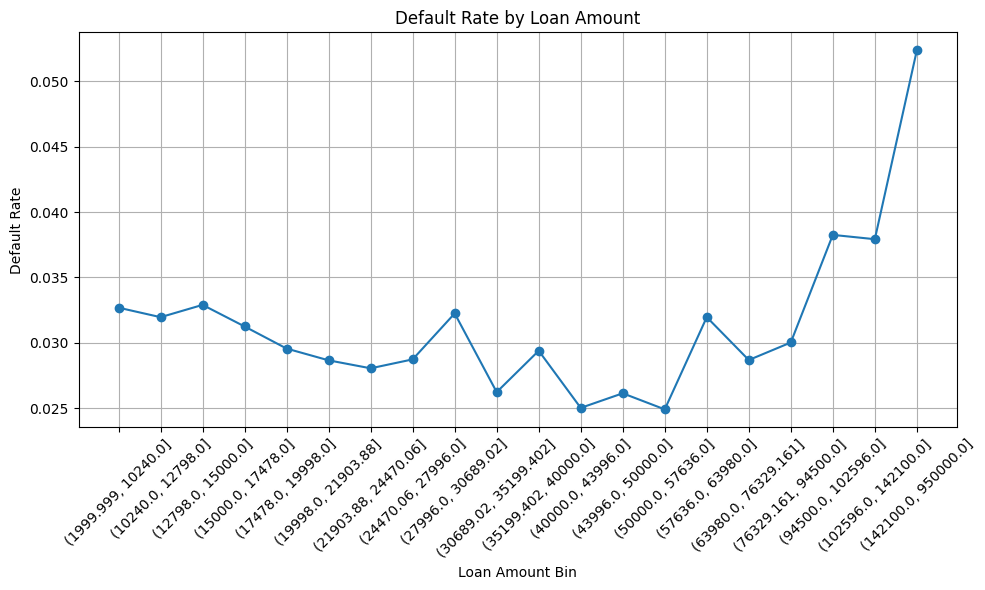

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

bins = pd.qcut(data_static_train['credamount_770A'], q=20, duplicates='drop') 
default_rate_by_bin = data_static_train.groupby(bins)['target'].mean().reset_index()
default_rate_by_bin.columns = ['Loan Amount Bin', 'Default Rate']


# Plot default rate by loan amount bin
plt.figure(figsize=(10, 6))
plt.plot(default_rate_by_bin['Loan Amount Bin'].astype(str), default_rate_by_bin['Default Rate'], marker='o')
plt.xticks(rotation=45)
plt.title('Default Rate by Loan Amount')
plt.xlabel('Loan Amount Bin')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.show()



## Other features

interestrate_311L / eir_270L

numactivecreds_622L - Number of active credits.


# Evaluating algorithms

## Recall = $\frac{TP}{TP + FN}$ , Specificity = $\frac{TN}{TN + FP}$ 

# FN = Incorrectly accepted a defaulter, FP = Incorrectly rejected a non-defaulter
# TN = Accepted correctly, TP = Rejected correctly

# Recent split

In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import train_test_split

def utility(tp, tn, fp, fn):
    #return 50*tp - 100*fn - fp * 5
    #return 150*tp + 3*tn - 10*fn - fp * 3
    #return 150*tp - 12*fn - fp * 2 + 4*tn
    return - 1*fn + 0.08*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util

def rf(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training pool for bandit modes
    first_key = sorted_keys[0]
    first_split = final_segments[first_key]
    last_accepted_data = (first_split[features], first_split['target'])

    for t in range(n_previous_splits, len(sorted_keys)):
        test_key = sorted_keys[t]

        # TRAINING DATA
        if mode == 'oracle':
            train_keys = sorted_keys[t - n_previous_splits:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        else:
            X_train, y_train = last_accepted_data

        # TEST DATA
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Safe stratified validation split
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=y_train
        )

        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        # Threshold tuning
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Decision logic
        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.random.rand(len(y_test_proba)) > 0.5
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Binary prediction for default (1 = default)
        y_test_pred = (y_test_proba >= best_threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        #pr_auc = average_precision_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()


        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            #"pr-auc": pr_auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update training pool only for bandit/epsilon
        if mode != 'oracle':
            last_accepted_data = (
                X_test.loc[accept_mask],
                y_test.loc[accept_mask]
            )

    return pd.DataFrame(results)


In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Utility function
def utility(tp, tn, fp, fn):
    return -1 * fn + 0.02 * tn

# Threshold tuning function
def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None

    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)

        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th

    return best_threshold, best_util

# Main evaluation function
def rf(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy', 'best'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training pool for bandit modes
    first_key = sorted_keys[0]
    first_split = final_segments[first_key]
    last_accepted_data = (first_split[features], first_split['target'])

    for t in range(n_previous_splits, len(sorted_keys)):
        test_key = sorted_keys[t]
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # === Determine training data ===
        if mode == 'oracle':
            train_keys = sorted_keys[t - n_previous_splits:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)

        elif mode == 'best':
            # Cheating oracle: train and test on same data
            X_train = X_test
            y_train = y_test

        else:
            X_train, y_train = last_accepted_data

        # === Model training and threshold tuning ===
        if mode == 'best':
            model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
            model.fit(X_train, y_train)
            y_test_proba = model.predict_proba(X_train)[:, 1]  # same set
            best_threshold, best_val_util = find_best_threshold(y_train, y_test_proba, thresholds)

        else:
            # Normal case: validation-based threshold tuning
            X_train_fit, X_val, y_train_fit, y_val = train_test_split(
                X_train, y_train, test_size=val_size,
                random_state=random_state, stratify=y_train
            )

            model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
            model.fit(X_train_fit, y_train_fit)
            y_val_proba = model.predict_proba(X_val)[:, 1]
            best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)
            y_test_proba = model.predict_proba(X_test)[:, 1]

        # === Decision logic ===
        if mode in ['oracle', 'bandit', 'best']:
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.random.rand(len(y_test_proba)) > 0.5
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # === Evaluation ===
        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Bandit modes: update training pool
        if mode not in ['oracle', 'best']:
            last_accepted_data = (
                X_test.loc[accept_mask],
                y_test.loc[accept_mask]
            )

    return pd.DataFrame(results)


In [39]:
df_rf_oracle = rf(final_segments, mode='oracle', n_previous_splits=1)
df_rf_bandit = rf(final_segments, mode='bandit', n_previous_splits=1)
df_rf_eps = rf(final_segments, mode='epsilon_greedy', epsilon=0.1)
#df_rf_best = rf(final_segments, mode='best')


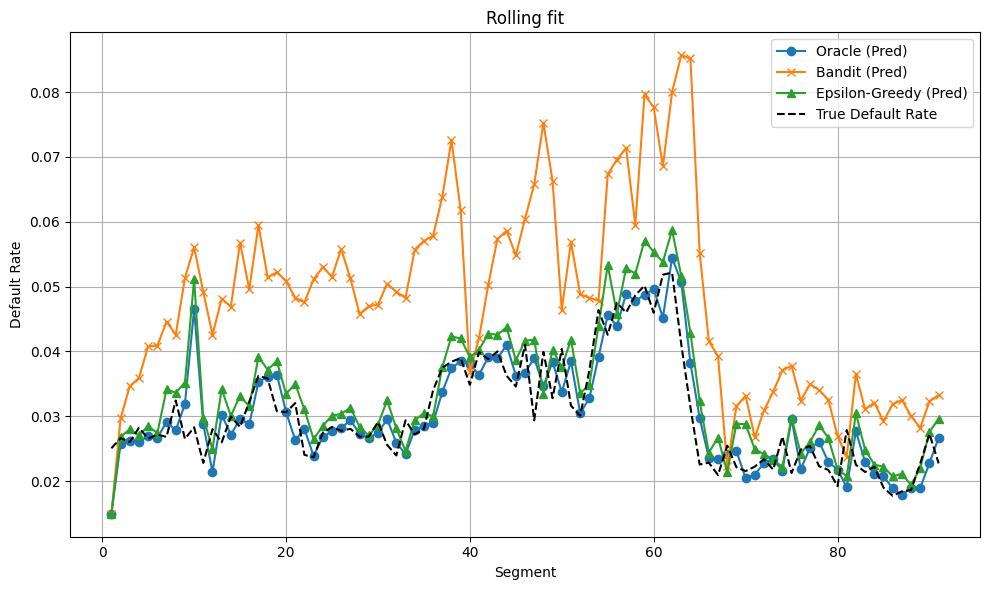

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_rf_oracle['segment_num'], df_rf_oracle['predicted_default_rate'], label='Oracle (Pred)', marker='o')
plt.plot(df_rf_bandit ['segment_num'], df_rf_bandit ['predicted_default_rate'], label='Bandit (Pred)', marker='x')
plt.plot(df_rf_eps['segment_num'], df_rf_eps['predicted_default_rate'], label='Epsilon-Greedy (Pred)', marker='^')
plt.plot(df_rf_oracle['segment_num'], df_rf_oracle['actual_default_rate'], label='True Default Rate', linestyle='--', color='black')

plt.xlabel('Segment')
plt.ylabel('Default Rate')
plt.title('Rolling fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('../Figures/Figure3.pdf', format='pdf', bbox_inches='tight')
plt.show()



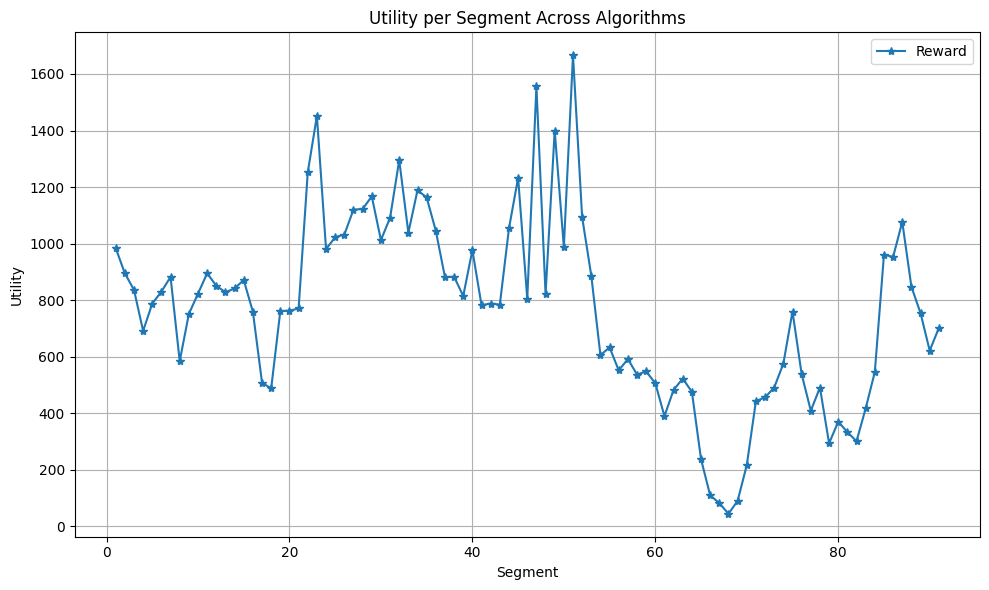

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot utility per segment for each mode
plt.plot(df_rf_oracle['segment_num'], df_rf_oracle['utility'], label='Reward', marker='*')

plt.xlabel('Segment')
plt.ylabel('Utility')
plt.title('Utility per Segment Across Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
df_rf_oracle[df_rf_oracle['tp']==0]

,segment,segment_num,type,threshold,utility,validation_utility,auc,recall,specificity,precision,accuracy,actual_default_rate,predicted_default_rate,accept_rate,exploration_rate,tn,fp,fn,tp
20,split_21,21,oracle_util_1splits,0.270256,770.04,153.76,0.624624,0.0,0.999635,0.0,0.967634,0.032013,0.026305,0.999646,0.0,16413,6,543,0
66,split_67,67,oracle_util_1splits,0.099231,81.28,26.36,0.588485,0.0,0.990741,0.0,0.970014,0.020921,0.023375,0.990934,0.0,1391,13,30,0
69,split_70,70,oracle_util_1splits,0.300000,215.36,17.72,0.566625,0.0,0.997585,0.0,0.976103,0.021534,0.020477,0.997637,0.0,3717,9,82,0
70,split_71,71,oracle_util_1splits,0.099231,442.24,44.68,0.595535,0.0,0.997805,0.0,0.975634,0.022219,0.020982,0.997854,0.0,7728,17,176,0
72,split_73,73,oracle_util_1splits,0.262821,490.28,97.32,0.642929,0.0,0.999176,0.0,0.977438,0.021757,0.023321,0.999194,0.0,8491,7,189,0
88,split_89,89,oracle_util_1splits,0.277692,753.48,170.44,0.681540,0.0,0.999248,0.0,0.976544,0.022721,0.018941,0.999265,0.0,13281,10,309,0


# Cumulative fit

In [14]:
def utility(tp, tn, fp, fn):
    #return 50*tp - 100*fn - fp * 5
    #return 150*tp + 3*tn - 10*fn - fp * 3
    #return 150*tp - 12*fn - fp * 2 + 4*tn
    return - 1*fn + 0.062*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util
def cf(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize pool with accepted from split_0 (accept all)
    accepted_X = [final_segments['split_0'][features]]
    accepted_y = [final_segments['split_0']['target']]

    for t in range(1, len(sorted_keys)):
        test_key = sorted_keys[t]

        # TRAINING DATA
        if mode == 'oracle':
            train_keys = sorted_keys[:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        else:
            X_train = pd.concat(accepted_X, ignore_index=True)
            y_train = pd.concat(accepted_y, ignore_index=True)

        # TEST DATA
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Safe stratified validation split
        stratify = y_train if y_train.nunique() > 1 else None
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=stratify
        )

        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        # Threshold tuning
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Decision logic
        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.random.rand(len(y_test_proba)) > 0.5
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Prediction for evaluation
        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update training pool (only for bandit/epsilon)
        if mode != 'oracle':
            accepted_X.append(X_test.loc[accept_mask])
            accepted_y.append(y_test.loc[accept_mask])

    return pd.DataFrame(results)


In [ ]:
df_cf_oracle = cf(final_segments, mode='oracle', n_previous_splits=1)
df_cf_bandit = cf(final_segments, mode='bandit', n_previous_splits=1)
df_cf_eps = cf(final_segments, mode='epsilon_greedy', epsilon=0.1)

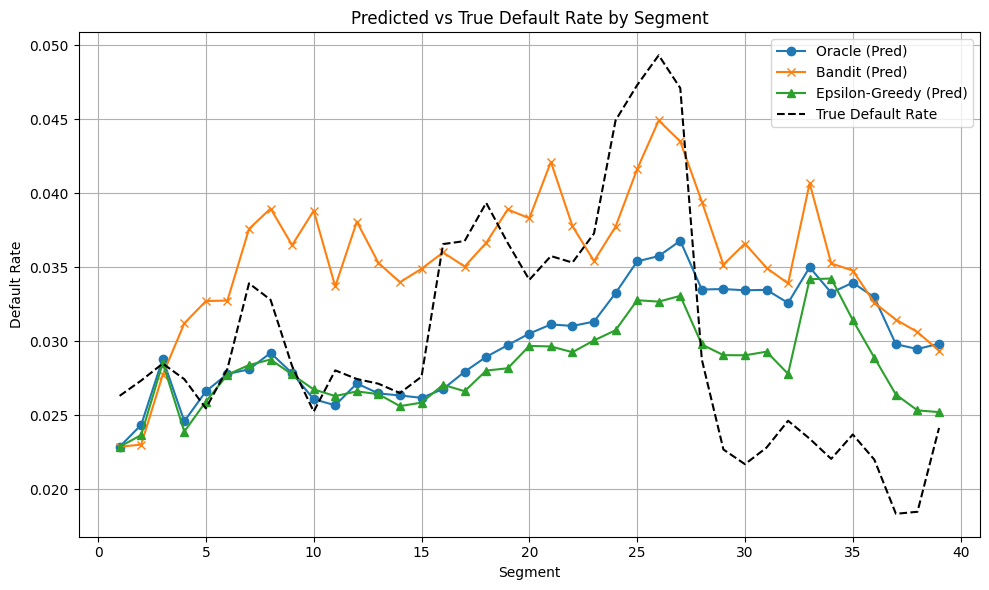

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_cf_oracle['segment_num'], df_cf_oracle['predicted_default_rate'], label='Oracle (Pred)', marker='o')
plt.plot(df_cf_bandit['segment_num'], df_cf_bandit['predicted_default_rate'], label='Bandit (Pred)', marker='x')
plt.plot(df_cf_eps['segment_num'], df_cf_eps['predicted_default_rate'], label='Epsilon-Greedy (Pred)', marker='^')

# All have same true default rate per segment, so just use one:
plt.plot(df_cf_oracle['segment_num'], df_cf_oracle['actual_default_rate'], label='True Default Rate', linestyle='--', color='black')

plt.xlabel('Segment')
plt.ylabel('Default Rate')
plt.title('Predicted vs True Default Rate by Segment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Online gradient descent

In [78]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

def utility(tp, tn, fp, fn):
    return - 1*fn + 0.03*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = 0.5
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        util = utility(tp, tn, fp, fn)
        if util > best_util:
            best_util = util
            best_threshold = th
    return best_threshold, best_util

def run_ogd_online(
    final_segments,
    epsilon=0.1,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42
):
    from sklearn.linear_model import SGDClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    from sklearn.model_selection import train_test_split

    results = []

    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

    X_train = final_segments['split_0'][features]
    y_train = final_segments['split_0']['target']

    # Define scaler and model
    scaler = StandardScaler()
    clf = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)

    #clf = SGDClassifier(
    #    loss='log_loss',
    #    max_iter=1,
    #   learning_rate='constant',  # constant learning rate strategy
    #    eta0=0.005,                 # initial (and constant) learning rate
    #    tol=None
    #)

    # Initial fit
    X_train_scaled = scaler.fit_transform(X_train)
    clf.partial_fit(X_train_scaled, y_train, classes=[0, 1])

    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(1, len(sorted_keys)):
        split_key = sorted_keys[t]
        test_segment = final_segments[split_key]
        X_test_full = test_segment[features]
        y_test_full = test_segment["target"]

        scaler.partial_fit(X_test_full)
        X_test_scaled = scaler.transform(X_test_full)

        # Split test segment into val/test to tune threshold
        X_val, X_test, y_val, y_test = train_test_split(
            X_test_scaled, y_test_full, test_size=1 - val_size,
            random_state=random_state, stratify=y_test_full if y_test_full.nunique() > 1 else None
        )

        # Tune threshold on validation data
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test data
        y_test_proba = clf.predict_proba(X_test)[:, 1]
        policy_accept = y_test_proba < best_threshold

        if mode == 'epsilon_greedy':
            rand = np.random.rand(len(y_test_proba))
            use_policy = rand >= epsilon
            explore_accept = np.random.rand(len(y_test_proba)) > 0.5
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (rand < epsilon).mean()
        else:
            accept_mask = policy_accept
            exploration_rate = 0.0

        y_test_pred = (y_test_proba >= best_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        auc = roc_auc_score(y_test, y_test_proba)
        recall = recall_score(y_test, y_test_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        util = utility(tp, tn, fp, fn)

        results.append({
            "segment": split_key,
            "segment_num": int(split_key.split("_")[1]),
            "type": mode,
            "threshold": best_threshold,
            "utility": util,
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "accuracy": accuracy,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "exploration_rate": exploration_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update model
        if mode == 'oracle':
            clf.partial_fit(X_test, y_test, classes=[0, 1])
        else:
            if accept_mask.any():
                clf.partial_fit(X_test[accept_mask], y_test[accept_mask], classes=[0, 1])

    return pd.DataFrame(results)


In [79]:
df_ogd_oracle = run_ogd_online(final_segments, mode='oracle')
df_ogd_bandit = run_ogd_online(final_segments, mode='bandit')
df_ogd_eps = run_ogd_online(final_segments, mode='epsilon_greedy', epsilon=0.05)

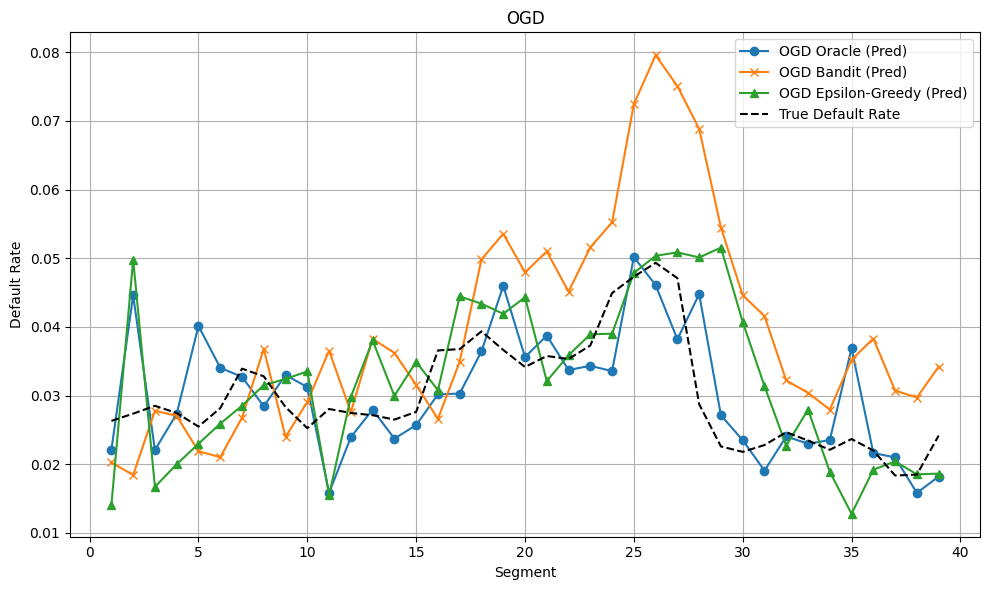

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_ogd_oracle['segment_num'], df_ogd_oracle['predicted_default_rate'],
         label='OGD Oracle (Pred)', marker='o')
plt.plot(df_ogd_bandit['segment_num'], df_ogd_bandit['predicted_default_rate'],
         label='OGD Bandit (Pred)', marker='x')
plt.plot(df_ogd_eps['segment_num'], df_ogd_eps['predicted_default_rate'],
         label='OGD Epsilon-Greedy (Pred)', marker='^')

# All have the same true default rate per segment, so use one
plt.plot(df_ogd_oracle['segment_num'], df_ogd_oracle['actual_default_rate'],
         label='True Default Rate', linestyle='--', color='black')

plt.xlabel('Segment')
plt.ylabel('Default Rate')
plt.title('OGD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



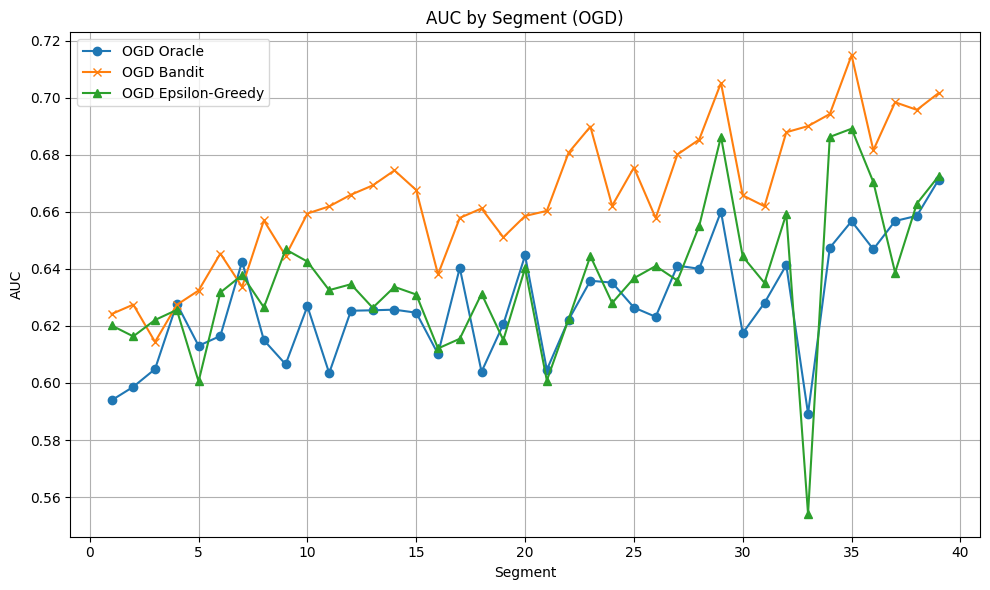

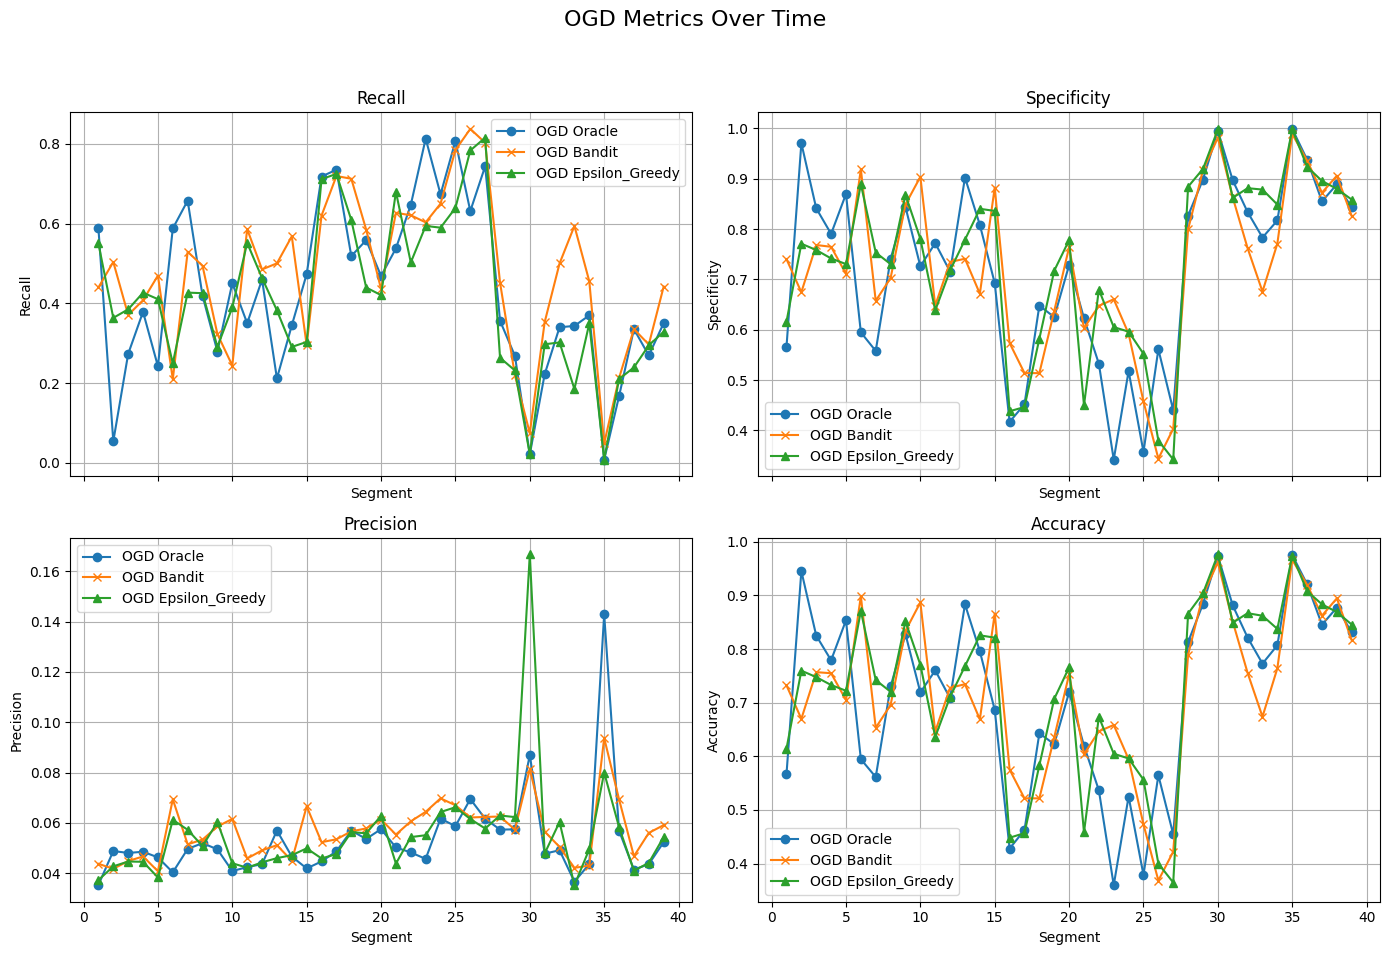

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_ogd_oracle['segment_num'], df_ogd_oracle['auc'], label='OGD Oracle', marker='o')
plt.plot(df_ogd_bandit['segment_num'], df_ogd_bandit['auc'], label='OGD Bandit', marker='x')
plt.plot(df_ogd_eps['segment_num'], df_ogd_eps['auc'], label='OGD Epsilon-Greedy', marker='^')

plt.xlabel('Segment')
plt.ylabel('AUC')
plt.title('AUC by Segment (OGD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Grid of 4 metrics: recall, specificity, precision, f1
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

metrics = ['recall', 'specificity', 'precision', 'accuracy']
titles = ['Recall', 'Specificity', 'Precision', 'Accuracy']
markers = {'oracle': 'o', 'bandit': 'x', 'epsilon_greedy': '^'}

dfs = {
    'oracle': df_ogd_oracle,
    'bandit': df_ogd_bandit,
    'epsilon_greedy': df_ogd_eps
}

for ax, metric, title in zip(axs.flat, metrics, titles):
    for label, df in dfs.items():
        ax.plot(df['segment_num'], df[metric], label=f'OGD {label.title()}', marker=markers[label])
    ax.set_title(title)
    ax.set_xlabel('Segment')
    ax.set_ylabel(title)
    ax.grid(True)
    ax.legend()

plt.suptitle('OGD Metrics Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Random Forest

In [90]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

def utility(tp, tn, fp, fn):
    return - 1 * fn + 0.02*tn

def find_best_threshold(y_true, y_proba, thresholds):
    best_util = -np.inf
    best_threshold = None

    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tp, tn, fp, fn)

        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th

    return best_threshold, best_util

def run_oracle_with_utility_threshold(
    final_segments,
    n_previous_splits=1,
    thresholds=np.linspace(0.01, 0.3, 40),
    val_size=0.2,
    random_state=42,
    mode='oracle',  # 'oracle', 'bandit', 'epsilon_greedy'
    epsilon=0.1
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training pool for bandit modes
    first_key = sorted_keys[0]
    first_split = final_segments[first_key]
    last_accepted_data = (first_split[features], first_split['target'])

    for t in range(n_previous_splits, len(sorted_keys)):
        test_key = sorted_keys[t]

        # TRAINING DATA
        if mode == 'oracle':
            train_keys = sorted_keys[t - n_previous_splits:t]
            X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
            y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)
        else:
            X_train, y_train = last_accepted_data

        # TEST DATA
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Safe stratified validation split
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=val_size,
            random_state=random_state, stratify=y_train
        )

        # === Random Forest model with default parameters ===
        model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=random_state))
        model.fit(X_train_fit, y_train_fit)

        # Threshold tuning
        y_val_proba = model.predict_proba(X_val)[:, 1]
        best_threshold, best_val_util = find_best_threshold(y_val, y_val_proba, thresholds)

        # Predict on test
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Decision logic
        if mode == 'oracle':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'bandit':
            accept_mask = y_test_proba < best_threshold
            exploration_rate = 0.0
        elif mode == 'epsilon_greedy':
            random_vals = np.random.rand(len(y_test_proba))
            use_policy = random_vals >= epsilon
            explore_accept = np.random.rand(len(y_test_proba)) > 0.5
            policy_accept = y_test_proba < best_threshold
            accept_mask = np.where(use_policy, policy_accept, explore_accept)
            exploration_rate = (random_vals < epsilon).mean()

        # Binary prediction for default (1 = default)
        y_test_pred = (y_test_proba >= best_threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = accept_mask.mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"{mode}_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": utility(tp, tn, fp, fn),
            "validation_utility": best_val_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "precision": precision,
            "f1": f1,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "exploration_rate": exploration_rate if mode == 'epsilon_greedy' else 0.0,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Update training pool only for bandit/epsilon
        if mode != 'oracle':
            last_accepted_data = (
                X_test.loc[accept_mask],
                y_test.loc[accept_mask]
            )

    return pd.DataFrame(results)


In [91]:
df_oracle = run_oracle_with_utility_threshold(final_segments, mode='oracle', n_previous_splits=1)
df_bandit = run_oracle_with_utility_threshold(final_segments, mode='bandit', n_previous_splits=1)
df_eps = run_oracle_with_utility_threshold(final_segments, mode='epsilon_greedy', epsilon=0.1)

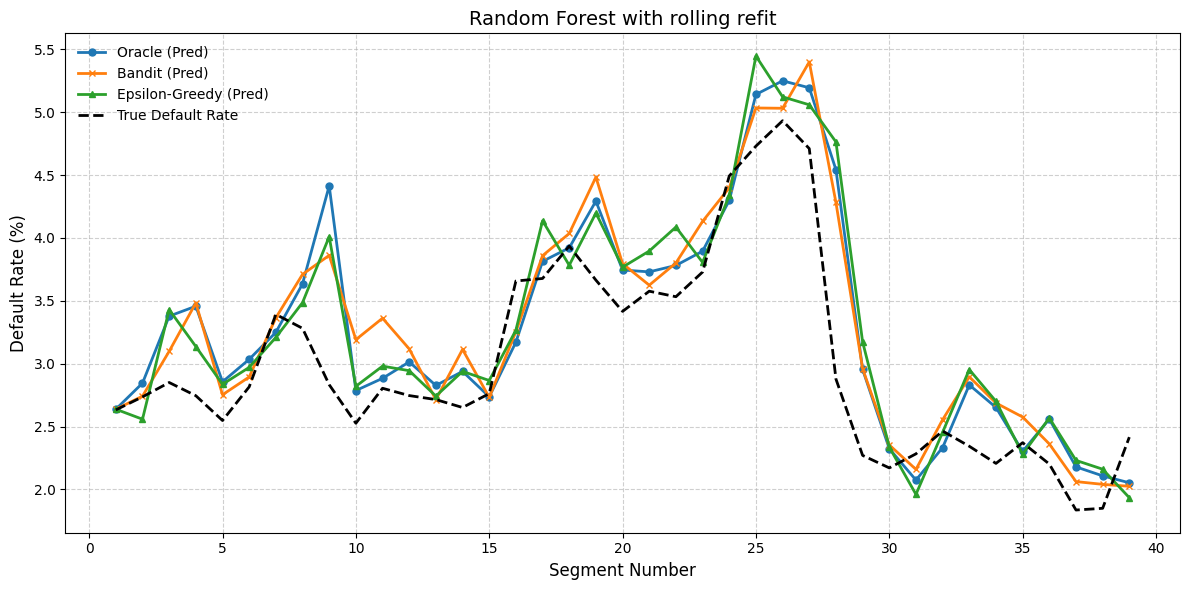

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot predicted default rates
plt.plot(df_oracle['segment_num'], df_oracle['predicted_default_rate'] * 100,
         label='Oracle (Pred)', marker='o', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['predicted_default_rate'] * 100,
         label='Bandit (Pred)', marker='x', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['predicted_default_rate'] * 100,
         label='Epsilon-Greedy (Pred)', marker='^', linestyle='-', linewidth=2, markersize=5)

# True default rate (same across all)
plt.plot(df_oracle['segment_num'], df_oracle['actual_default_rate'] * 100,
         label='True Default Rate', linestyle='--', color='black', linewidth=2)

# Axis labels and title
plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.title('Random Forest with rolling refit', fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=10, frameon=False)

# Improve spacing
plt.tight_layout()
plt.savefig('../Figures/Figure4.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


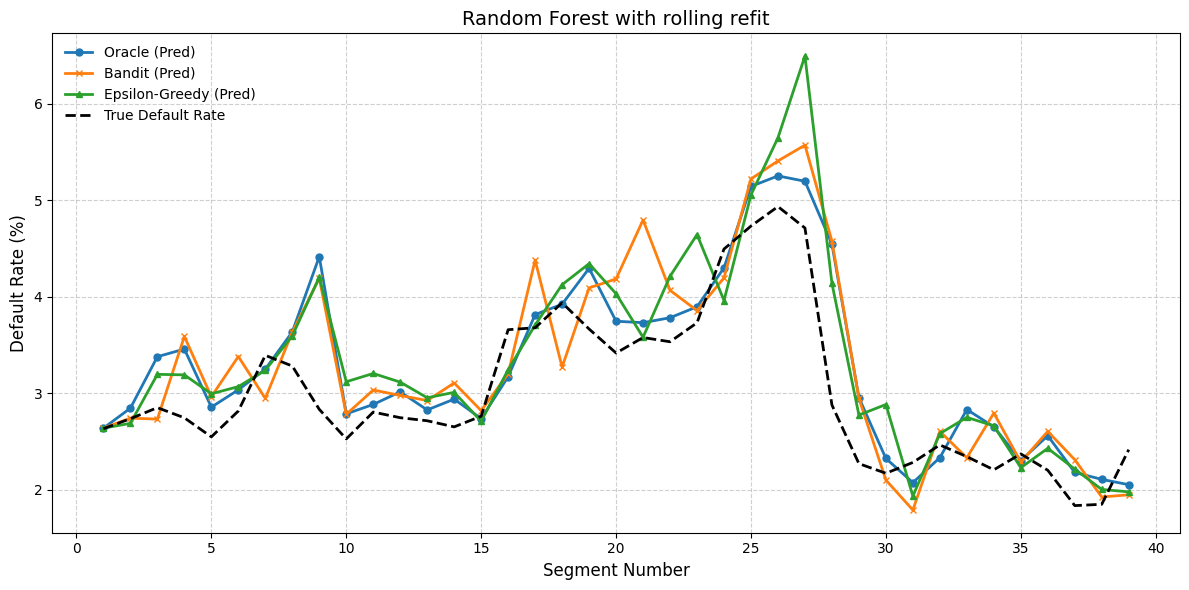

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot predicted default rates
plt.plot(df_oracle['segment_num'], df_oracle['predicted_default_rate'] * 100,
         label='Oracle (Pred)', marker='o', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['predicted_default_rate'] * 100,
         label='Bandit (Pred)', marker='x', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['predicted_default_rate'] * 100,
         label='Epsilon-Greedy (Pred)', marker='^', linestyle='-', linewidth=2, markersize=5)

# True default rate (same across all)
plt.plot(df_oracle['segment_num'], df_oracle['actual_default_rate'] * 100,
         label='True Default Rate', linestyle='--', color='black', linewidth=2)

# Axis labels and title
plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.title('Random Forest with rolling refit', fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=10, frameon=False)

# Improve spacing
plt.tight_layout()
plt.show()

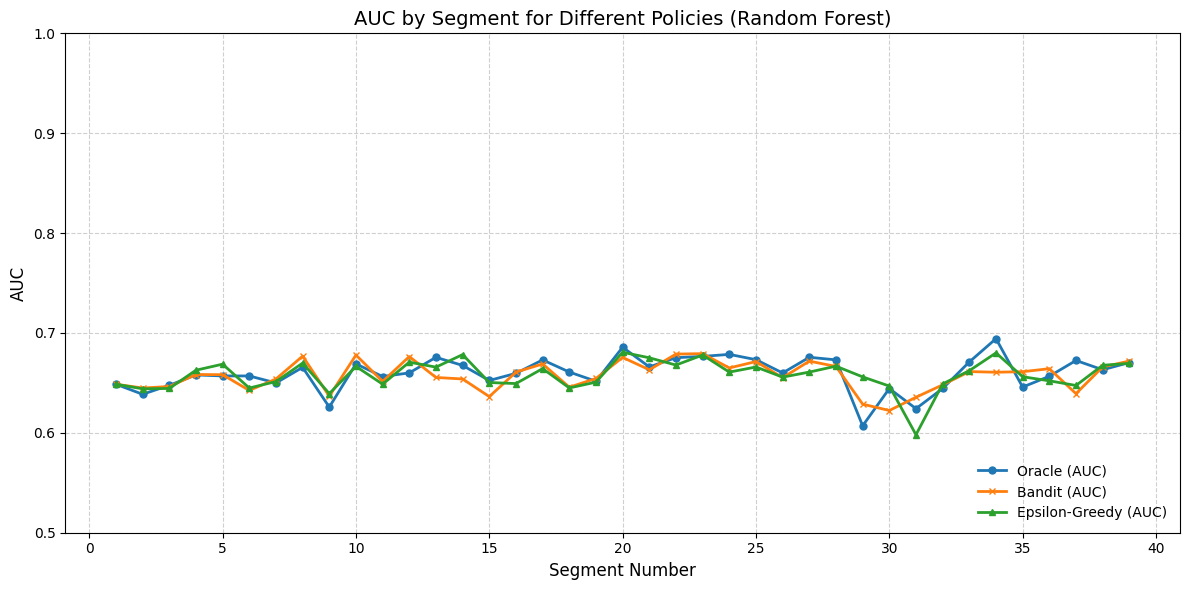

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot AUCs
plt.plot(df_oracle['segment_num'], df_oracle['auc'],
         label='Oracle (AUC)', marker='o', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['auc'],
         label='Bandit (AUC)', marker='x', linestyle='-', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['auc'],
         label='Epsilon-Greedy (AUC)', marker='^', linestyle='-', linewidth=2, markersize=5)

# Axis labels and title
plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC by Segment for Different Policies (Random Forest)', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10, frameon=False)

plt.ylim(0.5, 1.0)  # optional: to keep y-axis focused on meaningful AUC range
plt.tight_layout()
plt.show()


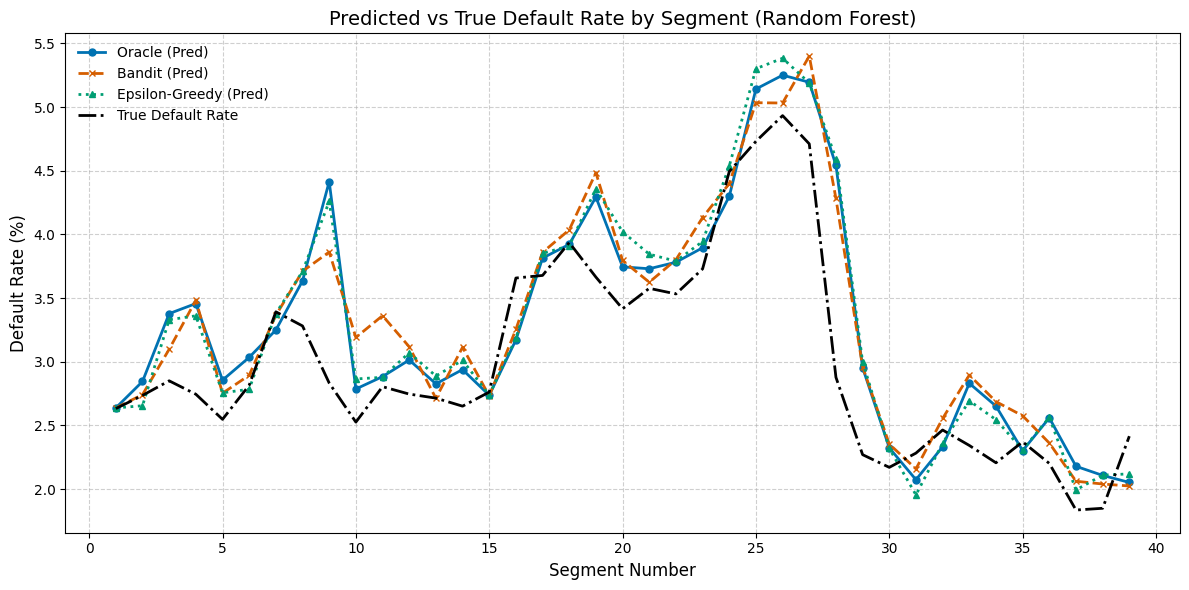

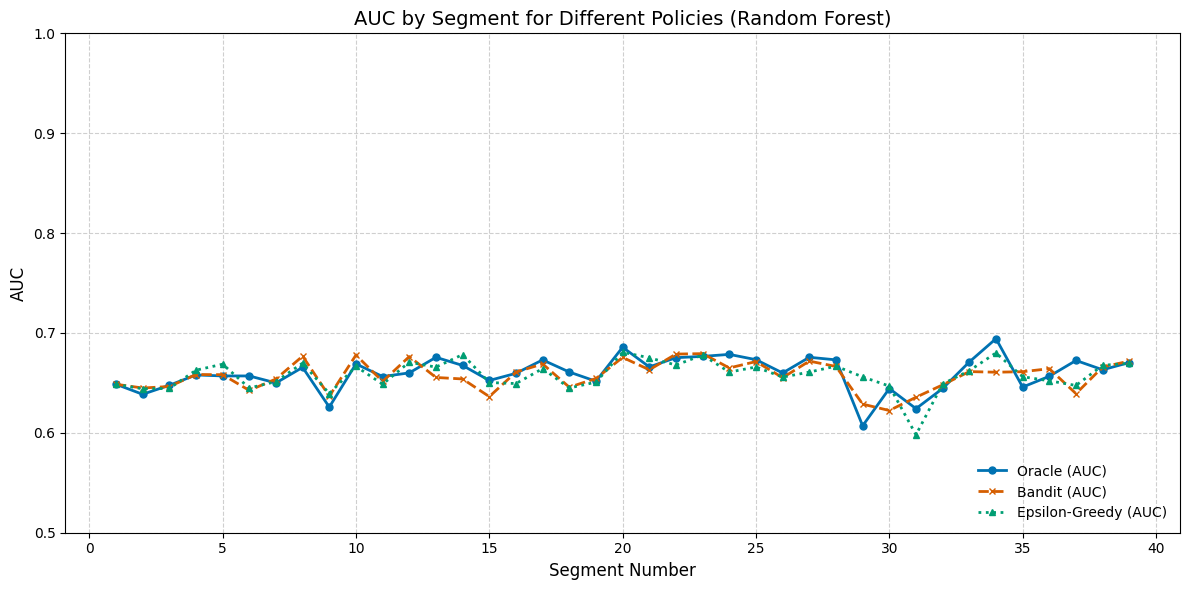

In [21]:
import matplotlib.pyplot as plt
from cycler import cycler

# Use a colorblind-friendly color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=['#0072B2', '#D55E00', '#009E73'])
plt.figure(figsize=(12, 6))

plt.plot(df_oracle['segment_num'], df_oracle['predicted_default_rate'] * 100,
         label='Oracle (Pred)', linestyle='-', marker='o', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['predicted_default_rate'] * 100,
         label='Bandit (Pred)', linestyle='--', marker='x', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['predicted_default_rate'] * 100,
         label='Epsilon-Greedy (Pred)', linestyle=':', marker='^', linewidth=2, markersize=5)

# True values
plt.plot(df_oracle['segment_num'], df_oracle['actual_default_rate'] * 100,
         label='True Default Rate', linestyle='-.', color='black', linewidth=2)

plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.title('Predicted vs True Default Rate by Segment (Random Forest)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=10, frameon=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(df_oracle['segment_num'], df_oracle['auc'],
         label='Oracle (AUC)', linestyle='-', marker='o', linewidth=2, markersize=5)

plt.plot(df_bandit['segment_num'], df_bandit['auc'],
         label='Bandit (AUC)', linestyle='--', marker='x', linewidth=2, markersize=5)

plt.plot(df_eps['segment_num'], df_eps['auc'],
         label='Epsilon-Greedy (AUC)', linestyle=':', marker='^', linewidth=2, markersize=5)

plt.xlabel('Segment Number', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('AUC by Segment for Different Policies (Random Forest)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=10, frameon=False)
plt.ylim(0.5, 1.0)  # Focus on meaningful AUC range
plt.tight_layout()
plt.show()


# Plots

In [153]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set clean style with white background
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

def create_algorithm_plots(results_df, figsize=(18, 12)):
    algorithms = ['rolling_refit', 'cumulative_refit', 'ogd']
    feedback_systems = ['bandit', 'epsilon_greedy', 'oracle']
    
    # Define better colors for each feedback system - more distinct and colorblind friendly
    colors = {
        'bandit': '#E74C3C',        # Red
        'epsilon_greedy': '#3498DB', # Blue  
        'oracle': '#2ECC71'         # Green
    }
    
    # Create figure with subplots - 2 rows, 3 columns
    fig = plt.figure(figsize=figsize)
    
    # Plot 1-3: Default Rates for each algorithm (actual + predicted)
    for i, algorithm in enumerate(algorithms):
        ax = plt.subplot(2, 3, i + 1)
        
        # Plot actual default rate only once (it's the same for all feedback systems)
        first_feedback = feedback_systems[0]
        data_actual = results_df[(results_df['algorithm'] == algorithm) & 
                               (results_df['feedback'] == first_feedback)]
        
        if not data_actual.empty:
            ax.plot(data_actual['segment_num'], data_actual['actual_default_rate'], 
                   color='#2C3E50', linestyle='-', linewidth=3, 
                   label='actual', marker='o', markersize=5, alpha=0.9)
        
        # Plot predicted default rates for each feedback system
        for feedback in feedback_systems:
            data = results_df[(results_df['algorithm'] == algorithm) & 
                            (results_df['feedback'] == feedback)]
            
            if not data.empty:
                ax.plot(data['segment_num'], data['predicted_default_rate'], 
                       color=colors[feedback], linestyle='--', linewidth=3, 
                       label=f'{feedback} (predicted)', marker='s', markersize=4, alpha=0.8)
        
        ax.set_title(f'{algorithm.replace("_", " ").title()}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Segment Number', fontsize=12)
        ax.set_ylabel('Default Rate', fontsize=12)
        ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
    
    # Plot 4-6: AUC for each algorithm
    for i, algorithm in enumerate(algorithms):
        ax = plt.subplot(2, 3, i + 4)
        
        for feedback in feedback_systems:
            data = results_df[(results_df['algorithm'] == algorithm) & 
                            (results_df['feedback'] == feedback)]
            
            if not data.empty:
                ax.plot(data['segment_num'], data['auc'], 
                       color=colors[feedback], linestyle='-', linewidth=3, 
                       label=feedback, marker='^', markersize=5)
        

        ax.set_xlabel('Segment Number', fontsize=12)
        ax.set_ylabel('AUC', fontsize=12)
        ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
        ax.set_ylim(0.4, 0.75)
    
    # Add single legend at the bottom of the figure
    handles = []
    labels = []
    
    # Add actual line
    line_actual = plt.Line2D([0], [0], color='#2C3E50', linewidth=3, linestyle='-', marker='o', markersize=5)
    handles.append(line_actual)
    labels.append('actual')
    
    # Add one entry for each feedback system (covers both predicted and AUC)
    for feedback in feedback_systems:
        line_feedback = plt.Line2D([0], [0], color=colors[feedback], linewidth=3, linestyle='-', markersize=4)
        handles.append(line_feedback)
        labels.append(feedback)
    
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig

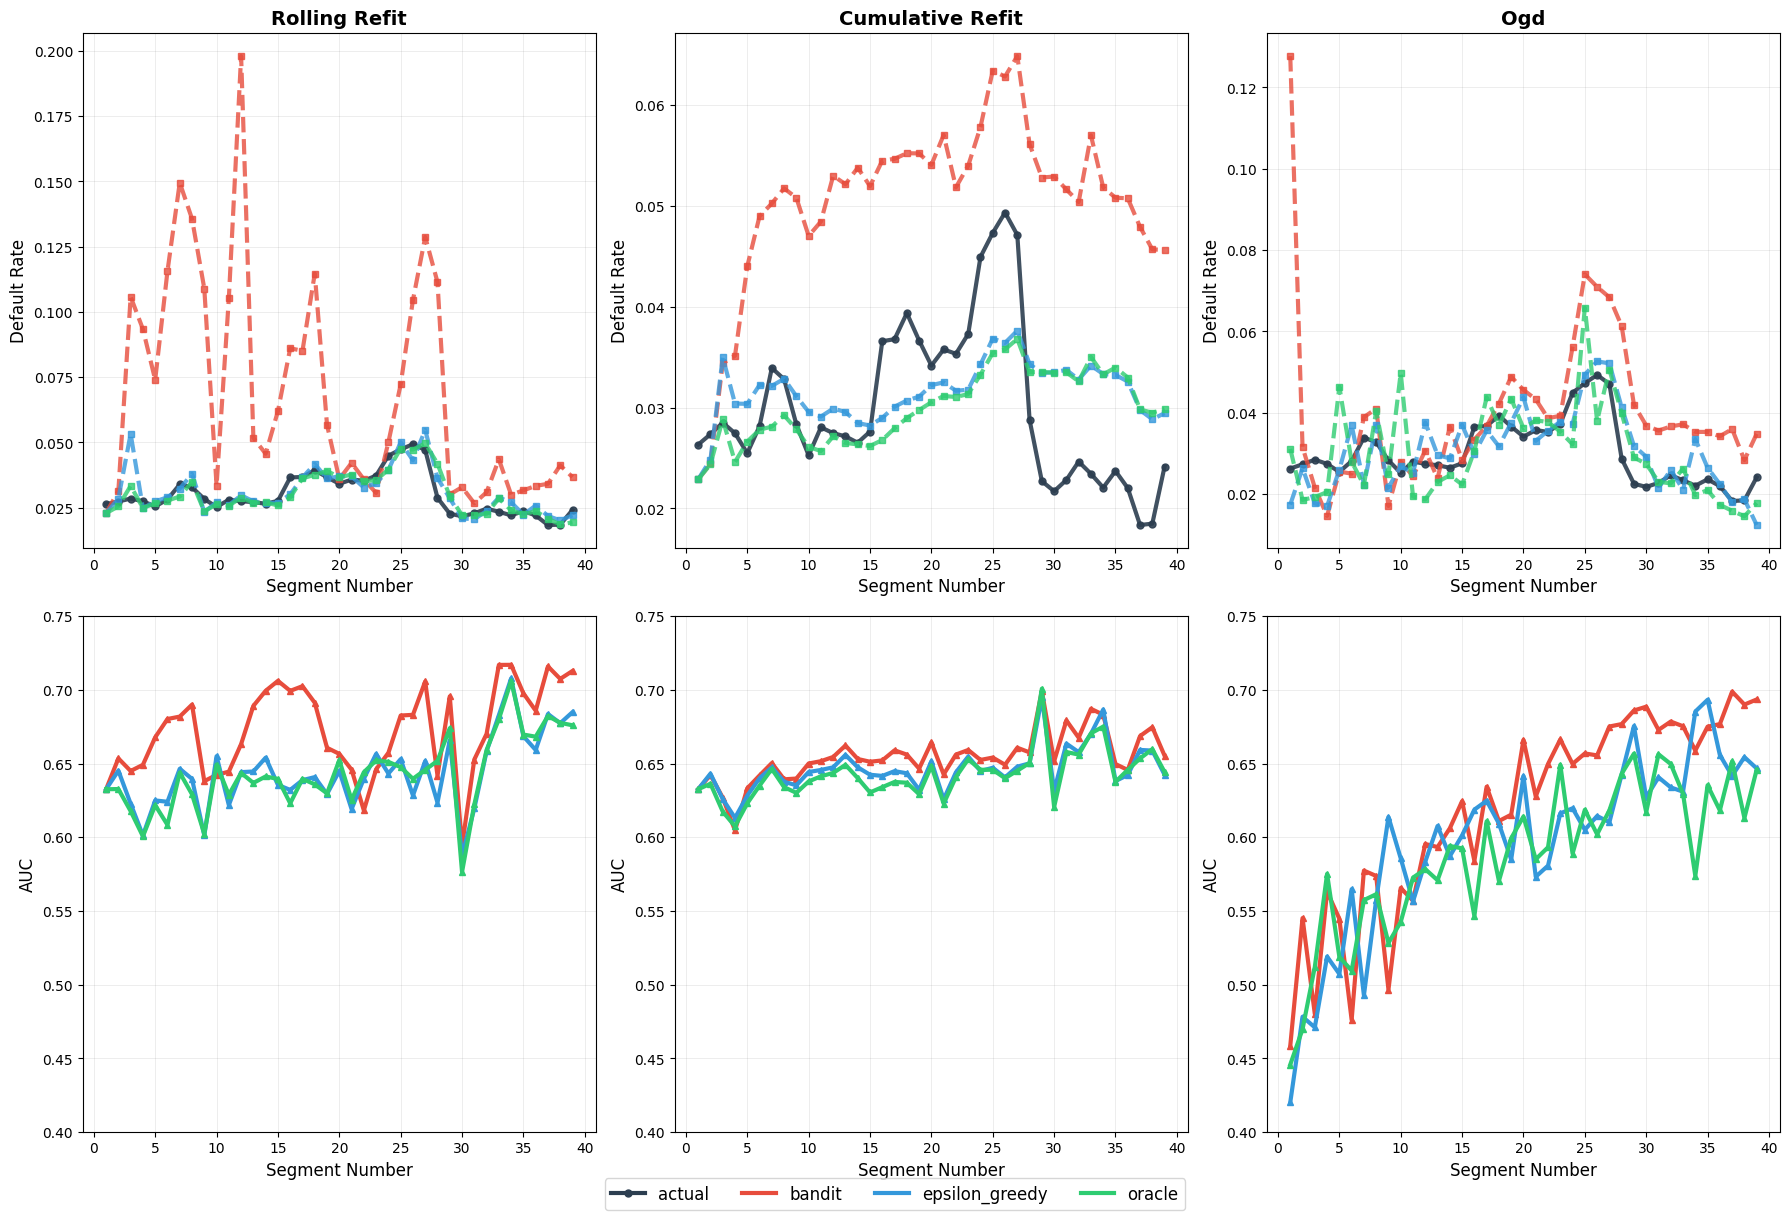

In [209]:
# First, combine all your DataFrames
df_cf_oracle['algorithm'] = 'cumulative_refit'
df_cf_oracle['feedback'] = 'oracle'

df_cf_bandit['algorithm'] = 'cumulative_refit'
df_cf_bandit['feedback'] = 'bandit'

df_cf_eps['algorithm'] = 'cumulative_refit'
df_cf_eps['feedback'] = 'epsilon_greedy'

df_rf_oracle['algorithm'] = 'rolling_refit'
df_rf_oracle['feedback'] = 'oracle'

df_rf_bandit['algorithm'] = 'rolling_refit'
df_rf_bandit['feedback'] = 'bandit'

df_rf_eps['algorithm'] = 'rolling_refit'
df_rf_eps['feedback'] = 'epsilon_greedy'

df_ogd_oracle['algorithm'] = 'ogd'
df_ogd_oracle['feedback'] = 'oracle'

df_ogd_bandit['algorithm'] = 'ogd'
df_ogd_bandit['feedback'] = 'bandit'

df_ogd_eps['algorithm'] = 'ogd'
df_ogd_eps['feedback'] = 'epsilon_greedy'

# Combine all DataFrames
results_df = pd.concat([
    df_cf_oracle, df_cf_bandit, df_cf_eps,
    df_rf_oracle, df_rf_bandit, df_rf_eps,
    df_ogd_oracle, df_ogd_bandit, df_ogd_eps
], ignore_index=True)

# Run the plotting function
fig1 = create_algorithm_plots(results_df)
fig1.savefig('../Figures/Figure1.pdf', format='pdf', bbox_inches='tight', dpi=300)

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set clean style with white background
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

def create_metrics_plots(results_df, figsize=(18, 16)):
    algorithms = ['rolling_refit', 'cumulative_refit', 'ogd']
    feedback_systems = ['bandit', 'epsilon_greedy', 'oracle']
    metrics = ['accuracy', 'precision', 'recall', 'specificity']
    
    # Define better colors for each feedback system - more distinct and colorblind friendly
    colors = {
        'bandit': '#E74C3C',        # Red
        'epsilon_greedy': '#3498DB', # Blue  
        'oracle': '#2ECC71'         # Green
    }
    
    # Create figure with 4x3 subplots (4 metrics x 3 algorithms)
    fig, axes = plt.subplots(4, 3, figsize=figsize)
    fig.suptitle('Performance Metrics Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for i, metric in enumerate(metrics):
        for j, algorithm in enumerate(algorithms):
            ax = axes[i, j]
            
            # Plot each feedback system for this algorithm and metric
            for feedback in feedback_systems:
                data = results_df[(results_df['algorithm'] == algorithm) & 
                                (results_df['feedback'] == feedback)]
                
                if not data.empty:
                    ax.plot(data['segment_num'], data[metric], 
                           color=colors[feedback], 
                           linestyle='-', 
                           linewidth=3, 
                           label=feedback, 
                           marker='o', 
                           markersize=4, 
                           alpha=0.8)
            
            # Formatting
            if i==0:
                title = f'{algorithm.replace("_", " ").title()}'
                ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Segment Number', fontsize=10)
            ax.set_ylabel(metric.title(), fontsize=10)
            ax.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
            
            # Set y-limits based on metric
            if metric == 'precision':
                ax.set_ylim(0, 0.2)
            else:
                ax.set_ylim(0, 1)
    
    # Create single legend for all plots
    handles = []
    labels = []
    
    # Add one entry for each feedback system
    for feedback in feedback_systems:
        line = plt.Line2D([0], [0], 
                        color=colors[feedback], 
                        linestyle='-', 
                        linewidth=3, 
                        marker='o', 
                        markersize=4)
        handles.append(line)
        labels.append(feedback)
    
    # Add legend at the bottom
    fig.legend(handles, labels, 
              loc='lower center', 
              bbox_to_anchor=(0.5, -0.02), 
              ncol=3, 
              fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, bottom=0.08)  # Make room for title and legend
    plt.show()
    
    return fig

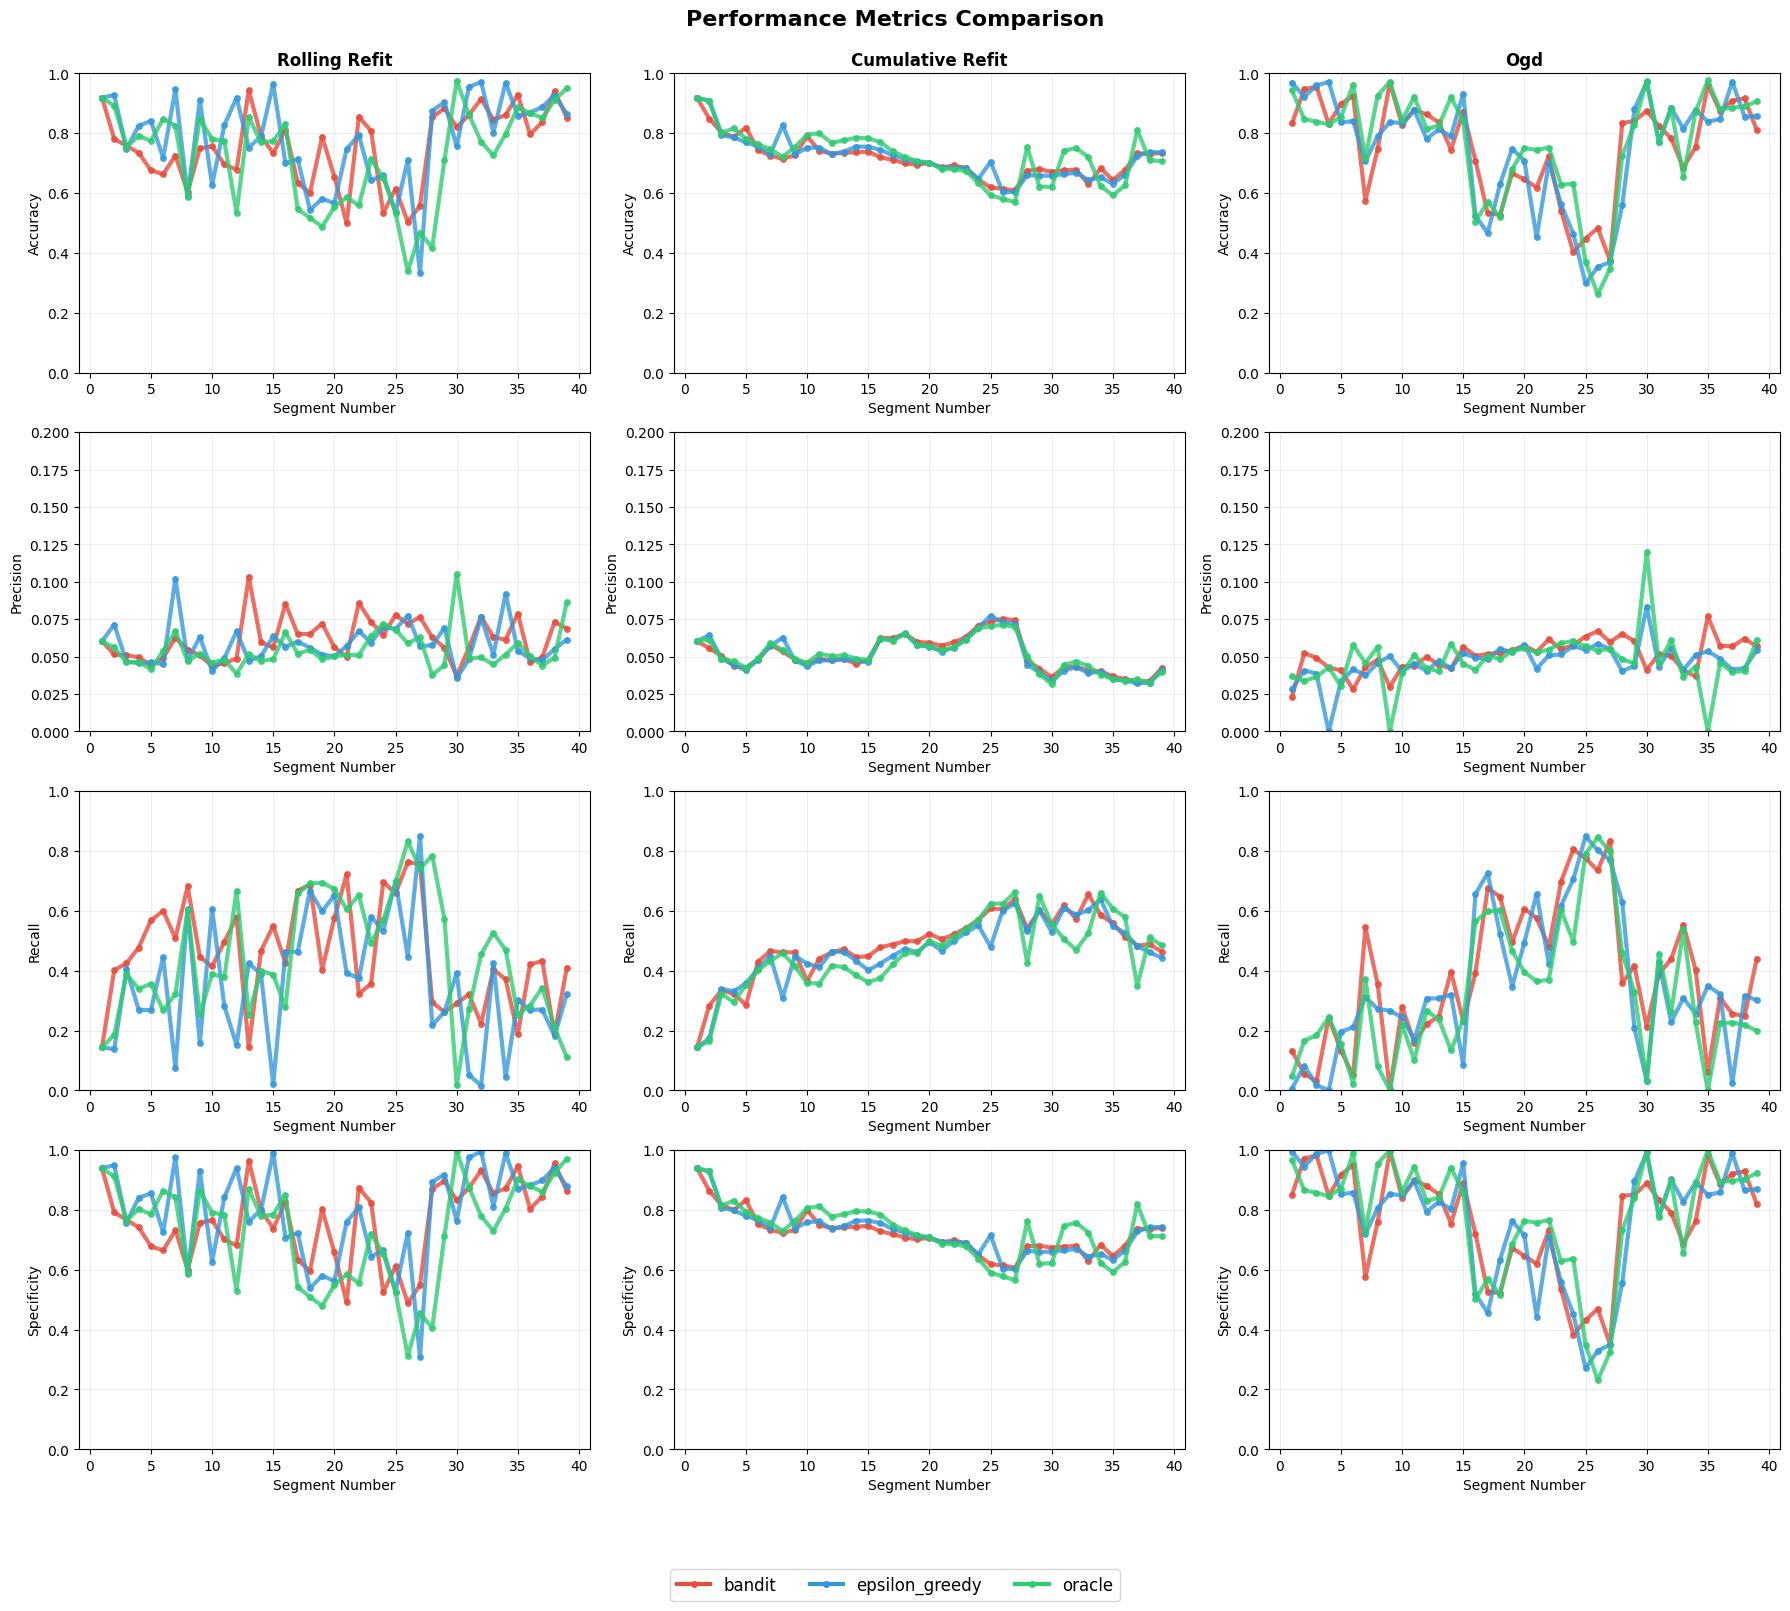

In [211]:
fig2 = create_metrics_plots(results_df)
fig2.savefig('../Figures/Figure2.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Utility optimisation 

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Utility factory
def make_utility(fn_weight, tn_weight):
    def utility(tn, fn):
        return fn_weight * fn + tn_weight * tn
    return utility

# 2. Oracle threshold tuner (cheating on test set)
def find_best_threshold_oracle(y_true, y_proba, thresholds, utility):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tn, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util

# 3. Main evaluation loop for oracle and fool
def evaluate_x_values(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.3, 40),
    random_state=42
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for x in x_values:
        utility_fn = make_utility(fn_weight=-1, tn_weight=x)  

        for t in range(0, len(sorted_keys)):
            test_key = sorted_keys[t]

            X_test = final_segments[test_key][features]
            y_test = final_segments[test_key]['target']

            # === ORACLE === #
            # Train and test on the same split
            model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
            model_oracle.fit(X_test, y_test)  # train on same set as predict
            y_test_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]

            best_threshold, best_util = find_best_threshold_oracle(y_test, y_test_proba_oracle, thresholds, utility_fn)
            y_pred_oracle = (y_test_proba_oracle >= best_threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()

            results.append({
                "x": x,
                "segment": test_key,
                "mode": "oracle",
                "threshold": best_threshold,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": (y_pred_oracle == 0).mean()
            })

            # === FOOL === #
            y_pred_fool = np.zeros_like(y_test)  # accepts everyone
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fool).ravel()

            results.append({
                "x": x,
                "segment": test_key,
                "mode": "fool",
                "threshold": None,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": 1.0
            })

    return pd.DataFrame(results)


In [19]:
x_values = np.append(1, np.arange(10, 151, 10))
  # From 0.1 to 10 (log scale)
results_df = evaluate_x_values(
    final_segments=final_segments,
    x_values=x_values,
    thresholds=np.linspace(0.01, 0.2, 40), 
    random_state=42
)


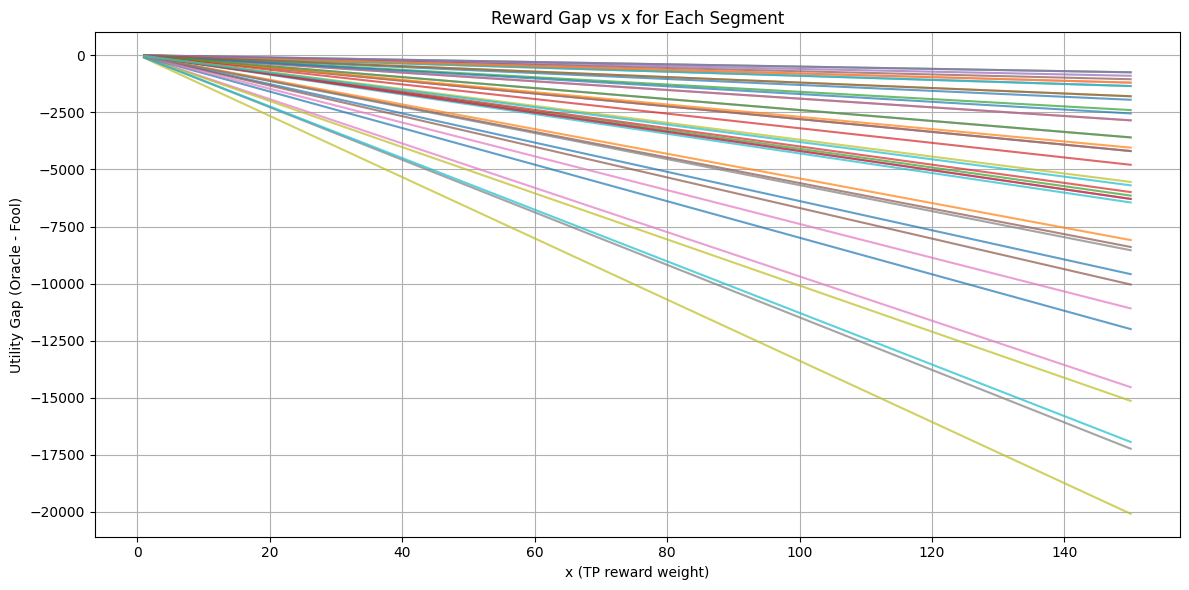

In [22]:
import matplotlib.pyplot as plt
# Pivot to get both utilities in the same row
pivot = results_df.pivot_table(index=['x', 'segment'], columns='mode', values='utility').reset_index()
pivot['reward_gap'] = pivot['oracle'] - pivot['fool']

# Plot reward gap
plt.figure(figsize=(12, 6))
for segment in sorted(pivot['segment'].unique()):
    subset = pivot[pivot['segment'] == segment]
    plt.plot(subset['x'], subset['reward_gap'], label=segment, alpha=0.7)

plt.xlabel('x (TP reward weight)')
plt.ylabel('Utility Gap (Oracle - Fool)')
plt.title('Reward Gap vs x for Each Segment')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
x_values2 = np.arange(0.01, 0.1001, 0.005)
  # From 0.1 to 10 (log scale)
results_df2 = evaluate_x_values(
    final_segments=final_segments,
    x_values=x_values2,
    thresholds=np.linspace(0.01, 0.2, 40), 
    random_state=42
)

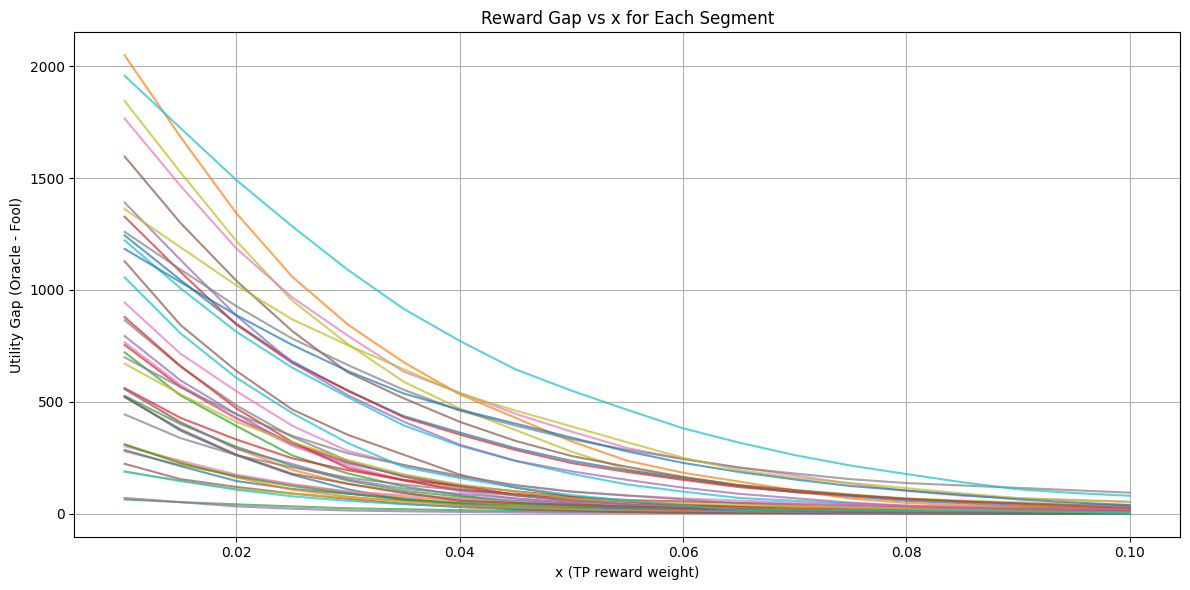

In [22]:
import matplotlib.pyplot as plt
# Pivot to get both utilities in the same row
pivot2 = results_df2.pivot_table(index=['x', 'segment'], columns='mode', values='utility').reset_index()
pivot2['reward_gap'] = pivot2['oracle'] - pivot2['fool']

# Plot reward gap
plt.figure(figsize=(12, 6))
for segment in sorted(pivot2['segment'].unique()):
    subset = pivot2[pivot2['segment'] == segment]
    plt.plot(subset['x'], subset['reward_gap'], label=segment, alpha=0.7)

plt.xlabel('x (TP reward weight)')
plt.ylabel('Utility Gap (Oracle - Fool)')
plt.title('Reward Gap vs x for Each Segment')
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# 1. Filter to x <= 0.2
filtered = pivot2#[pivot["x"] <= 0.2]

# 2. Group by x, and check if *all* reward_gaps are positive for that x
valid_x_values = (
    filtered.groupby("x")["reward_gap"]
    .apply(lambda g: (g > 0).all())  # True if all reward_gap > 0 for that x
)

# 3. Keep only x values where all reward_gap > 0
good_x = valid_x_values[valid_x_values].index

# 4. Final result: only rows where x is in good_x
final = filtered[filtered["x"].isin(good_x)]


Best conservative x = 0.010
  (Min reward gap across segments = 63.360)


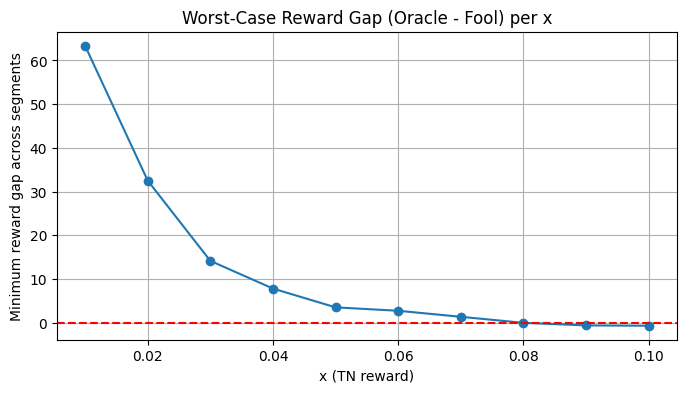

In [49]:
# 1. Filter x range if needed (optional)
filtered = pivot2

# 2. Compute the minimum reward_gap for each x across segments
worst_case_gap = filtered.groupby("x")["reward_gap"].min()

# 3. Find the x with the highest minimum reward_gap
best_x = worst_case_gap.idxmax()
best_min_gap = worst_case_gap.max()

print(f"Best conservative x = {best_x:.3f}")
print(f"  (Min reward gap across segments = {best_min_gap:.3f})")

# 4. Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
worst_case_gap.plot(marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Worst-Case Reward Gap (Oracle - Fool) per x")
plt.xlabel("x (TN reward)")
plt.ylabel("Minimum reward gap across segments")
plt.grid(True)
plt.show()


In [36]:
def evaluate_x_values(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.3, 40),
    random_state=42
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for x in x_values:
        utility_fn = make_utility(fn_weight=-1, tn_weight=x)

        for t in range(1, len(sorted_keys)):
            test_key = sorted_keys[t]
            test_data = final_segments[test_key]
            X_test = test_data[features]
            y_test = test_data['target']

            # === ORACLE ===
            model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
            model_oracle.fit(X_test, y_test) 
            y_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
            best_threshold_oracle, best_util_oracle = find_best_threshold_oracle(y_test, y_proba_oracle, thresholds, utility_fn)
            y_pred_oracle = (y_proba_oracle >= best_threshold_oracle).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()

            results.append({
                "x": x, "segment": test_key, "mode": "oracle",
                "threshold": best_threshold_oracle,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": (y_pred_oracle == 0).mean()
            })

            # === FOOL ===
            y_pred_fool = np.zeros_like(y_test)  # accepts everyone
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fool).ravel()

            results.append({
                "x": x, "segment": test_key, "mode": "fool",
                "threshold": None,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": 1.0
            })

            # === LOGISTIC (train on previous, test on current) ===
            prev_key = sorted_keys[t - 1]
            train_data = final_segments[prev_key]
            X_train = train_data[features]
            y_train = train_data['target']

            model_log = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
            X_train_fit, X_val, y_train_fit, y_val = train_test_split(
                X_train, y_train, test_size=0.2, stratify=y_train, random_state=random_state)

            model_log.fit(X_train_fit, y_train_fit)
            y_val_proba = model_log.predict_proba(X_val)[:, 1]

            # Threshold tuning on validation
            best_threshold_log, _ = find_best_threshold_oracle(y_val, y_val_proba, thresholds, utility_fn)

            # Predict on test
            y_test_proba = model_log.predict_proba(X_test)[:, 1]
            y_pred_log = (y_test_proba >= best_threshold_log).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log).ravel()

            results.append({
                "x": x, "segment": test_key, "mode": "logistic",
                "threshold": best_threshold_log,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": (y_pred_log == 0).mean()
            })

    return pd.DataFrame(results)


In [37]:
x_values2 = np.arange(0.01, 0.1001, 0.005)
results_df2 = evaluate_x_values(
    final_segments=final_segments,
    x_values=x_values2,
    thresholds=np.linspace(0.01, 0.2, 40), 
    random_state=42
)

Best x vs. fool: x = 0.010, min reward gap = 63.360
Best x vs. logistic: x = 0.060, min reward gap = 2.200


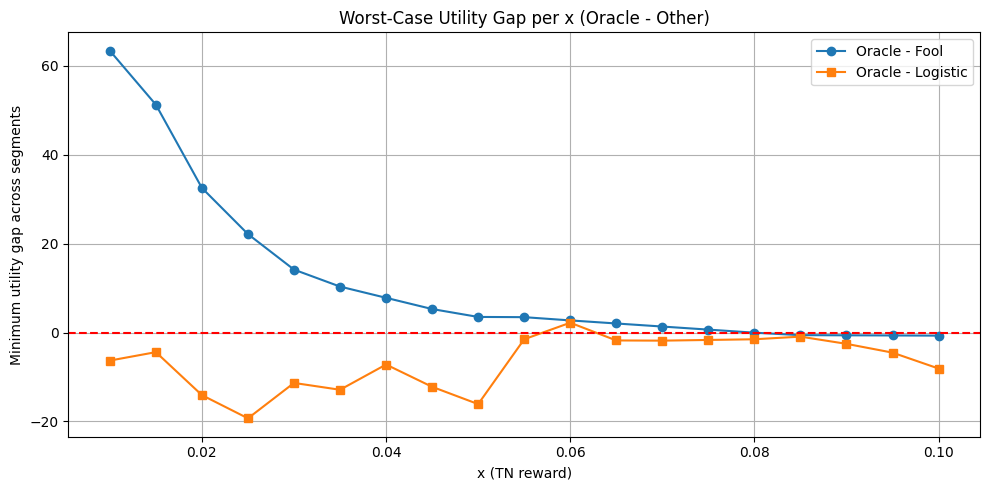

In [38]:
import matplotlib.pyplot as plt

# Pivot to compare oracle vs fool and oracle vs logistic
pivot = results_df2.pivot_table(index=['x', 'segment'], columns='mode', values='utility').reset_index()

# Compute reward gaps
pivot['gap_oracle_fool'] = pivot['oracle'] - pivot['fool']
pivot['gap_oracle_logistic'] = pivot['oracle'] - pivot['logistic']

# Optionally filter x range
filtered = pivot

# Compute worst-case (minimum) gap across segments for each x
worst_case_gap_fool = filtered.groupby('x')['gap_oracle_fool'].min()
worst_case_gap_logistic = filtered.groupby('x')['gap_oracle_logistic'].min()

# Find best x for each strategy
best_x_fool = worst_case_gap_fool.idxmax()
best_gap_fool = worst_case_gap_fool.max()

best_x_logistic = worst_case_gap_logistic.idxmax()
best_gap_logistic = worst_case_gap_logistic.max()

# Print summary
print(f"Best x vs. fool: x = {best_x_fool:.3f}, min reward gap = {best_gap_fool:.3f}")
print(f"Best x vs. logistic: x = {best_x_logistic:.3f}, min reward gap = {best_gap_logistic:.3f}")

# Plot both gaps
plt.figure(figsize=(10, 5))
plt.plot(worst_case_gap_fool, marker='o', label='Oracle - Fool')
plt.plot(worst_case_gap_logistic, marker='s', label='Oracle - Logistic')
plt.axhline(0, color='red', linestyle='--')
plt.title("Worst-Case Utility Gap per x (Oracle - Other)")
plt.xlabel("x (TN reward)")
plt.ylabel("Minimum utility gap across segments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Utility factory
def make_utility(fn_weight, tn_weight):
    def utility(tn, fn):
        return fn_weight * fn + tn_weight * tn
    return utility

# 2. Oracle threshold tuner (cheating on test set)
def find_best_threshold_oracle(y_true, y_proba, thresholds, utility):
    best_util = -np.inf
    best_threshold = None
    
    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        trial_util = utility(tn, fn)
        
        if trial_util > best_util:
            best_util = trial_util
            best_threshold = th
    
    return best_threshold, best_util

def evaluate_x_values(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.3, 40),
    random_state=42
):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(1, len(sorted_keys)):
        test_key = sorted_keys[t]
        prev_key = sorted_keys[t - 1]

        # === Load data ===
        test_data = final_segments[test_key]
        X_test = test_data[features]
        y_test = test_data['target']

        train_data = final_segments[prev_key]
        X_train = train_data[features]
        y_train = train_data['target']

        # === Oracle model: train on test ===
        model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        model_oracle.fit(X_test, y_test)
        y_test_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]

        # === Fool predictions ===
        y_pred_fool = np.zeros_like(y_test)
        tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test, y_pred_fool).ravel()

        # === Logistic model: train on previous ===
        model_log = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
        X_train_fit, X_val, y_train_fit, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=random_state)
        model_log.fit(X_train_fit, y_train_fit)
        y_val_proba = model_log.predict_proba(X_val)[:, 1]
        y_test_proba_log = model_log.predict_proba(X_test)[:, 1]

        for x in x_values:
            utility_fn = make_utility(fn_weight=-1, tn_weight=x)

            # === Oracle ===
            best_threshold_oracle, _ = find_best_threshold_oracle(y_test, y_test_proba_oracle, thresholds, utility_fn)
            y_pred_oracle = (y_test_proba_oracle >= best_threshold_oracle).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()

            results.append({
                "x": x, "segment": test_key, "mode": "oracle",
                "threshold": best_threshold_oracle,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": (y_pred_oracle == 0).mean()
            })

            # === Fool ===
            results.append({
                "x": x, "segment": test_key, "mode": "fool",
                "threshold": None,
                "utility": utility_fn(tn_f, fn_f),
                "tp": tp_f, "tn": tn_f, "fp": fp_f, "fn": fn_f,
                "accept_rate": 1.0
            })

            # === Logistic ===
            best_threshold_log, _ = find_best_threshold_oracle(y_val, y_val_proba, thresholds, utility_fn)
            y_pred_log = (y_test_proba_log >= best_threshold_log).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log).ravel()

            results.append({
                "x": x, "segment": test_key, "mode": "logistic",
                "threshold": best_threshold_log,
                "utility": utility_fn(tn, fn),
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "accept_rate": (y_pred_log == 0).mean()
            })

    return pd.DataFrame(results)


In [ ]:
x_values2 = np.arange(0.01, 0.1001, 0.005)
  # From 0.1 to 10 (log scale)
results_df2 = evaluate_x_values(
    final_segments=final_segments,
    x_values=x_values2,
    thresholds=np.linspace(0.01, 0.2, 40), 
    random_state=42
)

In [ ]:
x_values3 = np.arange(0.05, 0.0701, 0.001)

results_df3 = evaluate_x_values(
    final_segments=final_segments,
    x_values=x_values3,
    thresholds=np.linspace(0.01, 0.2, 40), 
    random_state=42
)


In [43]:
def make_utility(fn_weight, tn_weight):
    def utility(tn, fn):
        return fn_weight * fn + tn_weight * tn
    return utility

def find_best_threshold_oracle_fast(y_true, y_proba, thresholds, utility_fn):
    best_util = -np.inf
    best_threshold = None

    for th in thresholds:
        accept = y_proba < th
        tn = np.sum((accept) & (y_true == 0))
        fn = np.sum((accept) & (y_true == 1))
        util = utility_fn(tn, fn)
        if util > best_util:
            best_util = util
            best_threshold = th

    return best_threshold, best_util
def evaluate_segment(test_key, prev_key, final_segments, features, x_values, thresholds, random_state):
    results = []

    # Load data
    X_test = final_segments[test_key][features]
    y_test = final_segments[test_key]['target'].astype(int)  # Ensure binary
    X_train = final_segments[prev_key][features]
    y_train = final_segments[prev_key]['target'].astype(int)  # Ensure binary

    # === Oracle ===
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
    model_oracle.fit(X_test.copy(), y_test.copy())
    y_test_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]

    # === Logistic ===
    model_log = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=random_state))
    X_train_fit, X_val, y_train_fit, y_val = train_test_split(
        X_train.copy(), y_train.copy(), test_size=0.2, stratify=y_train.copy(), random_state=random_state
    )
    model_log.fit(X_train_fit.copy(), y_train_fit.copy())
    y_val_proba = model_log.predict_proba(X_val)[:, 1]
    y_test_proba_log = model_log.predict_proba(X_test)[:, 1]

    # === Fool baseline ===
    y_pred_fool = np.zeros_like(y_test)
    tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test, y_pred_fool).ravel()

    for x in x_values:
        utility_fn = make_utility(fn_weight=-1, tn_weight=x)

        # --- Oracle ---
        th_oracle, _ = find_best_threshold_oracle_fast(y_test, y_test_proba_oracle, thresholds, utility_fn)
        pred_oracle = (y_test_proba_oracle >= th_oracle).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, pred_oracle).ravel()
        results.append({
            "x": x, "segment": test_key, "mode": "oracle",
            "threshold": th_oracle,
            "utility": utility_fn(tn, fn),
            "tp": tp, "tn": tn, "fp": fp, "fn": fn,
            "accept_rate": (pred_oracle == 0).mean()
        })

        # --- Fool ---
        results.append({
            "x": x, "segment": test_key, "mode": "fool",
            "threshold": None,
            "utility": utility_fn(tn_f, fn_f),
            "tp": tp_f, "tn": tn_f, "fp": fp_f, "fn": fn_f,
            "accept_rate": 1.0
        })

        # --- Logistic ---
        th_log, _ = find_best_threshold_oracle_fast(y_val, y_val_proba, thresholds, utility_fn)
        pred_log = (y_test_proba_log >= th_log).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, pred_log).ravel()
        results.append({
            "x": x, "segment": test_key, "mode": "logistic",
            "threshold": th_log,
            "utility": utility_fn(tn, fn),
            "tp": tp, "tn": tn, "fp": fp, "fn": fn,
            "accept_rate": (pred_log == 0).mean()
        })

    return results





In [44]:
from joblib import Parallel, delayed
from functools import partial

def evaluate_x_values_parallel(
    final_segments,
    x_values,
    thresholds=np.linspace(0.01, 0.3, 40),
    random_state=42,
    n_jobs=-1  # use all cores
):
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
    features = [col for col in final_segments['split_0'].columns if col not in {'case_id', 'WEEK_NUM', 'target'}]

    jobs = [(sorted_keys[t], sorted_keys[t - 1]) for t in range(1, len(sorted_keys))]

    # Wrap function to pass fixed args
    evaluate_fn = partial(
        evaluate_segment,
        final_segments=final_segments,
        features=features,
        x_values=x_values,
        thresholds=thresholds,
        random_state=random_state
    )

    all_results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(evaluate_fn)(test_key, prev_key) for test_key, prev_key in jobs
    )

    # Flatten and return DataFrame
    return pd.DataFrame([row for segment in all_results for row in segment])


In [45]:
x_values = np.arange(0.051, 0.2, 0.001)
#x_values = np.arange(0.1, 10, 0.2)
results_df = evaluate_x_values_parallel(final_segments, x_values, n_jobs=4)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   36.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  91 out of  91 | elapsed:  3.7min finished


Best x vs. fool: x = 0.051, min reward gap = 2.188
Best x vs. logistic: x = 0.084, min reward gap = 1.756


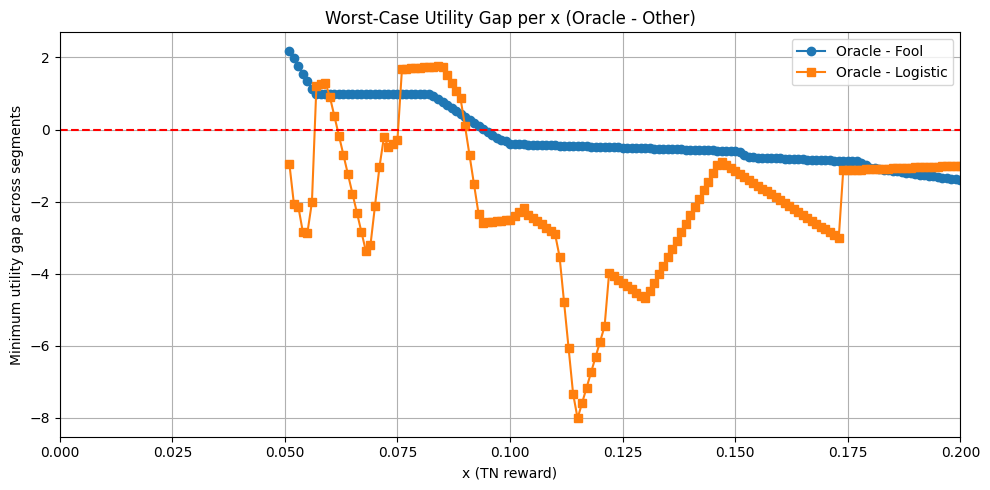

In [46]:
import matplotlib.pyplot as plt

# Pivot to compare oracle vs fool and oracle vs logistic
pivot = results_df.pivot_table(index=['x', 'segment'], columns='mode', values='utility').reset_index()

# Compute reward gaps
pivot['gap_oracle_fool'] = pivot['oracle'] - pivot['fool']
pivot['gap_oracle_logistic'] = pivot['oracle'] - pivot['logistic']

# Optionally filter x range
filtered = pivot

# Compute worst-case (minimum) gap across segments for each x
worst_case_gap_fool = filtered.groupby('x')['gap_oracle_fool'].min()
worst_case_gap_logistic = filtered.groupby('x')['gap_oracle_logistic'].min()

# Find best x for each strategy
best_x_fool = worst_case_gap_fool.idxmax()
best_gap_fool = worst_case_gap_fool.max()

best_x_logistic = worst_case_gap_logistic.idxmax()
best_gap_logistic = worst_case_gap_logistic.max()

# Print summary
print(f"Best x vs. fool: x = {best_x_fool:.3f}, min reward gap = {best_gap_fool:.3f}")
print(f"Best x vs. logistic: x = {best_x_logistic:.3f}, min reward gap = {best_gap_logistic:.3f}")

# Plot both gaps
plt.figure(figsize=(10, 5))
plt.plot(worst_case_gap_fool, marker='o', label='Oracle - Fool')
plt.plot(worst_case_gap_logistic, marker='s', label='Oracle - Logistic')
plt.axhline(0, color='red', linestyle='--')
plt.title("Worst-Case Utility Gap per x (Oracle - Other)")
plt.xlim((0,0.2))
plt.xlabel("x (TN reward)")
plt.ylabel("Minimum utility gap across segments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()